# Proyecto ISIS-3302 (Modelado, Optimización y Simulación)

- Paulina Arrazola Vernaza - 202020631
- Santiago Alejandro Jaimes Puerto - 201912921
- Nicolás Rincón Sánchez - 202021963

# Etapa III (Metaheurística)

## 1. Implementación de Metaheurísticas (GA)

### 1.1 Importación de Librerías

In [5]:
import pandas as pd
import numpy as np
import random
import math
import requests
import time
import os
import json
import itertools 
from collections import OrderedDict
import sys
import matplotlib.pyplot as plt
import csv

### 1.2 Carga y estructuración de los datos

In [10]:
import os
import sys
import json
import itertools
from collections import OrderedDict

import pandas as pd
import requests

OSRM_URL = "https://router.project-osrm.org/table/v1/driving/"
C_KM = 20700  # COP/km. Esta constante se saca del análisis realizado en la etapa 1 de costos de transporte 

GA_DATA = {
    "depot_id": None,
    "depot_coords": None,
    "client_ids": [],
    "client_coords": {}, 
    "client_demands": {},
    "all_node_ids": [],
    "all_node_coords": {}, 
    "vehicle_capacity": [], 
    "vehicle_range": [], 
    "num_available_vehicles": 0,
    "distance_matrix": {},
    "cost_matrix": {}, 
}

def load_data(case_name_str):

    # Estructura
    GA_DATA["depot_id"] = None
    GA_DATA["depot_coords"] = None
    GA_DATA["client_ids"] = []
    GA_DATA["client_coords"] = {}
    GA_DATA["client_demands"] = {}
    GA_DATA["all_node_ids"] = []
    GA_DATA["all_node_coords"] = {}
    GA_DATA["vehicle_capacity"] = [] 
    GA_DATA["vehicle_range"] = []  
    GA_DATA["num_available_vehicles"] = 0
    GA_DATA["distance_matrix"] = {}
    GA_DATA["cost_matrix"] = {}

    base_data_path = "Etapa3/data/Proyecto_A_"
    depots_df_path = f"{base_data_path}CasoBase/depots.csv"

    if case_name_str == "Base":
        clients_df_path = f"{base_data_path}CasoBase/clients.csv"
        vehicles_df_path = f"{base_data_path}CasoBase/vehicles.csv"
    elif case_name_str == "2":
        clients_df_path = f"{base_data_path}Caso2/clients.csv"
        vehicles_df_path = f"{base_data_path}Caso2/vehicles.csv"
    elif case_name_str == "3":
        clients_df_path = f"{base_data_path}Caso3/clients.csv"
        vehicles_df_path = f"{base_data_path}Caso3/vehicles.csv"
    else:
        print(f"Error: Nombre de caso desconocido '{case_name_str}'", file=sys.stderr)
        sys.exit(1)

    try:
        depots_df = pd.read_csv(depots_df_path)
        if depots_df.empty:
            raise ValueError(f"El archivo de depósitos ({depots_df_path}) está vacío o no se encontró.")
        first_depot_row = depots_df.iloc[0]
        GA_DATA["depot_id"] = f"D{int(first_depot_row['DepotID'])}"
        GA_DATA["depot_coords"] = (float(first_depot_row['Latitude']), float(first_depot_row['Longitude']))
        GA_DATA["all_node_ids"].append(GA_DATA["depot_id"])
        GA_DATA["all_node_coords"][GA_DATA["depot_id"]] = GA_DATA["depot_coords"]

        clients_df = pd.read_csv(clients_df_path)
        if clients_df.empty:
            raise ValueError(f"El archivo de clientes ({clients_df_path}) está vacío o no se encontró.")
        if 'Demand' not in clients_df.columns:
            raise ValueError(f"Falta la columna 'Demand' en {clients_df_path}.")
        for idx, row in clients_df.iterrows():
            client_id_val = row['ClientID']
            if isinstance(client_id_val, float) and client_id_val.is_integer():
                client_id_val = int(client_id_val)
            client_id_str = f"C{client_id_val}"
            GA_DATA["client_ids"].append(client_id_str)
            GA_DATA["all_node_ids"].append(client_id_str)
            client_coords = (float(row['Latitude']), float(row['Longitude']))
            GA_DATA["client_coords"][client_id_str] = client_coords
            GA_DATA["all_node_coords"][client_id_str] = client_coords
            GA_DATA["client_demands"][client_id_str] = float(row['Demand'])
        print(f"Se cargaron {len(GA_DATA['client_ids'])} clientes para el caso {case_name_str}. Ejemplos: {GA_DATA['client_ids'][:5]}")

        vehicles_df = pd.read_csv(vehicles_df_path)
        if vehicles_df.empty:
            raise ValueError(f"El archivo de vehículos ({vehicles_df_path}) está vacío o no se encontró.")
        if 'Range' not in vehicles_df.columns or 'Capacity' not in vehicles_df.columns:
            raise ValueError(f"Faltan las columnas 'Range' o 'Capacity' en {vehicles_df_path}.")

        GA_DATA["vehicle_range"] = vehicles_df['Range'].tolist()
        GA_DATA["vehicle_capacity"] = vehicles_df['Capacity'].tolist()
        GA_DATA["num_available_vehicles"] = len(vehicles_df)

    except FileNotFoundError as e:
        print(f"Archivo no encontrado. {e}", file=sys.stderr)
        sys.exit(1)
    except ValueError as e: 
        print(f"Problema con los datos. {e}", file=sys.stderr)
        sys.exit(1)
    except KeyError as e: 
        print(f"Falta una columna esperada en el CSV. Columna problemática: {e}", file=sys.stderr)
        sys.exit(1)
    except Exception as e:
        print(f"Ocurrió un error inesperado durante la carga de datos: {e}", file=sys.stderr)
        sys.exit(1)

    # Calculo OSRM de distancias
    print("--- Calculando matriz de distancias con OSRM ---")
    N_ga = GA_DATA["all_node_ids"]
    coords_ga = GA_DATA["all_node_coords"]
    if not GA_DATA["client_ids"]:
         print(f"No se cargaron clientes para el caso {case_name_str}. El algoritmo genético no puede continuar.", file=sys.stderr)
    CACHE_FILE_GA = f'Etapa3/cache/osrm_cache_ga_{case_name_str.lower().replace(" ", "_")}.json'
    os.makedirs(os.path.dirname(CACHE_FILE_GA), exist_ok=True)

    dist_cache = {}
    if os.path.exists(CACHE_FILE_GA):
        try:
            with open(CACHE_FILE_GA, 'r') as f:
                raw_cache = json.load(f)
            dist_cache = {tuple(k.split("|")): v for k, v in raw_cache.items()}
            print(f"  Distancias cargadas desde el caché GA ({len(dist_cache)} pares): {CACHE_FILE_GA}")
        except json.JSONDecodeError:
            dist_cache = {}
    
    all_pairs_to_calculate = list(itertools.product(N_ga, N_ga))
    missing_pairs = [p for p in all_pairs_to_calculate if p not in dist_cache and p[0] != p[1]] 

    MAX_COORDS_OSRM = 100 

    if missing_pairs:
        BATCH_SIZE = max(1, MAX_COORDS_OSRM // 2) 
        
        for i_start_node_batch_start in range(0, len(N_ga), BATCH_SIZE):
            sources_nodes = N_ga[i_start_node_batch_start : i_start_node_batch_start + BATCH_SIZE]
            
            for j_start_node_batch_start in range(0, len(N_ga), BATCH_SIZE):
                dests_nodes = N_ga[j_start_node_batch_start : j_start_node_batch_start + BATCH_SIZE]
                
                current_query_nodes = list(OrderedDict.fromkeys(sources_nodes + dests_nodes)) 
                if not current_query_nodes: continue

                node_to_idx_map = {node_id: k for k, node_id in enumerate(current_query_nodes)}
                query_coords_str = ";".join([f"{coords_ga[n][1]},{coords_ga[n][0]}" for n in current_query_nodes])
                
                src_indices_in_query = ";".join(str(node_to_idx_map[n]) for n in sources_nodes if n in node_to_idx_map)
                dst_indices_in_query = ";".join(str(node_to_idx_map[n]) for n in dests_nodes if n in node_to_idx_map)

                if not src_indices_in_query or not dst_indices_in_query: continue

                url_batch = f"{OSRM_URL}{query_coords_str}"
                params_batch = {
                    "sources": src_indices_in_query,
                    "destinations": dst_indices_in_query,
                    "annotations": "distance"
                }
                try:
                    r = requests.get(url_batch, params=params_batch, timeout=180)
                    r.raise_for_status()
                    matrix_data = r.json()
                    if "distances" not in matrix_data or not matrix_data["distances"]:
                        for u_node_s in sources_nodes:
                            for v_node_d in dests_nodes:
                                if (u_node_s, v_node_d) not in dist_cache: dist_cache[(u_node_s, v_node_d)] = float('inf')
                        continue
                    
                    batch_distances = matrix_data["distances"]
                    for src_idx_local, u_node_s in enumerate(sources_nodes):
                        for dst_idx_local, v_node_d in enumerate(dests_nodes):
                            if u_node_s == v_node_d:
                                dist_cache[(u_node_s, v_node_d)] = 0.0
                                continue
                            if src_idx_local < len(batch_distances) and dst_idx_local < len(batch_distances[src_idx_local]):
                                dist_val = batch_distances[src_idx_local][dst_idx_local]
                                dist_cache[(u_node_s, v_node_d)] = float('inf') if dist_val is None else dist_val / 1000.0
                            else:
                                dist_cache[(u_node_s, v_node_d)] = float('inf')

                except requests.exceptions.Timeout:
                    print(f"    Error: la solicitud a OSRM excedió el tiempo para el batch. Se asigna Inf.")
                    for u_node_s in sources_nodes:
                        for v_node_d in dests_nodes:
                            if (u_node_s, v_node_d) not in dist_cache: dist_cache[(u_node_s, v_node_d)] = float('inf')
                except requests.exceptions.RequestException as e_req:
                    print(f"    Error: la solicitud a OSRM falló para el batch: {e_req}. Se asigna Inf.")
                    for u_node_s in sources_nodes:
                        for v_node_d in dests_nodes:
                            if (u_node_s, v_node_d) not in dist_cache: dist_cache[(u_node_s, v_node_d)] = float('inf')
        
        ordered_dist_cache_to_save = OrderedDict()
        sorted_nodes_for_cache = sorted(N_ga) 
        for u_node in sorted_nodes_for_cache:
            for v_node in sorted_nodes_for_cache:
                ordered_dist_cache_to_save[f"{u_node}|{v_node}"] = dist_cache.get((u_node, v_node), float('inf') if u_node !=v_node else 0.0)

        with open(CACHE_FILE_GA, 'w') as f:
            json.dump(ordered_dist_cache_to_save, f, indent=2)
        print(f"  Caché de OSRM para GA actualizado: {CACHE_FILE_GA}")
    else:
        print(f"  No hay pares de distancias faltantes para el caso {case_name_str}")

    for u_node in N_ga:
        for v_node in N_ga:
            if u_node == v_node:
                GA_DATA["distance_matrix"][(u_node, v_node)] = 0.0
                GA_DATA["cost_matrix"][(u_node, v_node)] = 0.0
            else:
                dist = dist_cache.get((u_node, v_node), float('inf'))
                GA_DATA["distance_matrix"][(u_node, v_node)] = dist
                GA_DATA["cost_matrix"][(u_node, v_node)] = dist * C_KM
    
    print(f"Matrices de distancia y costo generadas para el caso {case_name_str}. Total de entradas: {len(GA_DATA['distance_matrix'])}")
    if GA_DATA["depot_id"] in GA_DATA["client_ids"]: 
        print(f"¡El depósito con ID {GA_DATA['depot_id']} también aparece en la lista de clientes para el caso {case_name_str}!", file=sys.stderr)
        sys.exit(1)

    # Cargar los datos en una estructura de datos global
    globals()[f'GA_DATA_{case_name_str}'] = GA_DATA.copy() 
    print(f"--- DATOS CARGADOS PARA EL CASO {case_name_str} ---")


In [13]:
for case_name in ["Base", "2", "3"]:
    load_data(case_name)
    print(f"Datos cargados y procesados para el caso {case_name}.")
    print("\n")

Se cargaron 24 clientes para el caso Base. Ejemplos: ['C1', 'C2', 'C3', 'C4', 'C5']
--- Calculando matriz de distancias con OSRM ---
  Distancias cargadas desde el caché GA (625 pares): Etapa3/cache/osrm_cache_ga_base.json
  No hay pares de distancias faltantes para el caso Base
Matrices de distancia y costo generadas para el caso Base. Total de entradas: 625
--- DATOS CARGADOS PARA EL CASO Base ---
Datos cargados y procesados para el caso Base.


Se cargaron 9 clientes para el caso 2. Ejemplos: ['C1', 'C2', 'C3', 'C4', 'C5']
--- Calculando matriz de distancias con OSRM ---
  Distancias cargadas desde el caché GA (100 pares): Etapa3/cache/osrm_cache_ga_2.json
  No hay pares de distancias faltantes para el caso 2
Matrices de distancia y costo generadas para el caso 2. Total de entradas: 100
--- DATOS CARGADOS PARA EL CASO 2 ---
Datos cargados y procesados para el caso 2.


Se cargaron 90 clientes para el caso 3. Ejemplos: ['C1', 'C2', 'C3', 'C4', 'C5']
--- Calculando matriz de distancia

### 1.3 Algorítmo Genético (cromosomas, fitness, cruce, mutación, etc.)

In [7]:
# Decodifica un cromosoma en una lista de rutas. 
# Cada ruta comienza y termina en el depósito y respeta la capacidad y rango específicos del vehículo
def decode_chromosome_to_routes(chromosome, data):
    routes = []
    current_route_nodes = [data["depot_id"]]
    current_route_capacity_load = 0
    current_route_distance_travelled = 0
    current_vehicle_idx = 0
    
    total_solution_cost = 0
    feasibility_penalty = 0
    clients_to_visit_ordered = list(chromosome)
    chromosome_client_idx = 0

    # Ordenar los clientes para visitar en el orden del cromosoma
    while chromosome_client_idx < len(clients_to_visit_ordered):
        if current_vehicle_idx >= data["num_available_vehicles"]:
            # Si no hay más vehículos disponibles, penalizar por falta de viabilidad 
            remaining_unserved = len(clients_to_visit_ordered) - chromosome_client_idx
            feasibility_penalty += remaining_unserved * 10_000_000
            break

        
        client_id_to_try = clients_to_visit_ordered[chromosome_client_idx]
        client_demand = data["client_demands"].get(client_id_to_try, float('inf'))
        current_vehicle_capacity = data["vehicle_capacity"][current_vehicle_idx]
        current_vehicle_range = data["vehicle_range"][current_vehicle_idx]
        needs_new_vehicle = (len(current_route_nodes) == 1 and current_route_nodes[0] == data["depot_id"])
        
        # Si es el primer cliente de la ruta, verificar si se necesita un nuevo vehículo
        if needs_new_vehicle:
            current_route_capacity_load = 0
            current_route_distance_travelled = 0

        can_add_this_client = True
        last_node = current_route_nodes[-1]
        dist_to_client = data["distance_matrix"].get((last_node, client_id_to_try), float('inf'))
        dist_to_depot = data["distance_matrix"].get((client_id_to_try, data["depot_id"]), float('inf'))

        # Verificar capacidad y distancia
        if dist_to_client == float('inf') or dist_to_depot == float('inf'):
            can_add_this_client = False
            feasibility_penalty += 20_000_000

        # Calcular nueva carga y distancia si se agrega el cliente en la ruta
        new_load = current_route_capacity_load + client_demand
        new_distance = current_route_distance_travelled + dist_to_client + dist_to_depot

        if new_load > current_vehicle_capacity:
            can_add_this_client = False
        
        if new_distance > current_vehicle_range:
            can_add_this_client = False

        # Si las verificaciones son correctas, se agrega el cliente a la ruta
        if can_add_this_client:
            current_route_nodes.append(client_id_to_try)
            current_route_capacity_load = new_load
            current_route_distance_travelled += dist_to_client
            chromosome_client_idx += 1
        else:
            if needs_new_vehicle:
                # Penalizar por no poder servir al cliente con el vehículo actual
                feasibility_penalty += 50_000_000
                # Si no se puede servir al cliente con el vehículo actual se pasa al siguiente vehículo
                chromosome_client_idx += 1
            else:
                if len(current_route_nodes) > 1:
                    dist_return = data["distance_matrix"].get((current_route_nodes[-1], data["depot_id"]), float('inf'))
                    if dist_return == float('inf'):
                        # Penalizar por no regresar al depósito
                        feasibility_penalty += 20_000_000
                    else:
                        final_route_dist = current_route_distance_travelled + dist_return
                        # Costo de la ruta final que se calcula con la distancia final y el costo fijo por km
                        total_solution_cost += final_route_dist * C_KM
                    routes.append((current_vehicle_idx, list(current_route_nodes) + [data["depot_id"]]))
                current_route_nodes = [data["depot_id"]]
                current_route_capacity_load = 0
                current_route_distance_travelled = 0
                current_vehicle_idx += 1

    # Completar última ruta si es necesario
    if len(current_route_nodes) > 1:
        dist_return_last = data["distance_matrix"].get((current_route_nodes[-1], data["depot_id"]), float('inf'))
        if dist_return_last == float('inf'):
            # Penalizar por no ser capaz de regresar al depósito
            feasibility_penalty += 20_000_000
        else:
            final_route_dist = current_route_distance_travelled + dist_return_last
            total_solution_cost += final_route_dist * C_KM
        routes.append((current_vehicle_idx, list(current_route_nodes) + [data["depot_id"]]))

    # Verificar clientes no servidos
    served_clients = set()
    for _, route in routes:
        for node in route:
            if node != data["depot_id"]:
                served_clients.add(node)

    # Penalizar por clientes no servidos
    for client in chromosome:
        if client not in served_clients:
            feasibility_penalty += 1_000_000

    return routes, total_solution_cost, feasibility_penalty

# Calcula el fitness de un indiciduo
# Menos fitness (costo) es mejor
def calculate_cvrp_fitness(chromosome_individual, data):
    # Asegurar que el cromosoma contiende todos los clientes exactamente una vez
    if sorted(chromosome_individual) != sorted(data["client_ids"]):
        return float('inf') # Cromosoma invalido se penaliza con infinito

    routes, decoded_cost, penalty = decode_chromosome_to_routes(chromosome_individual, data)
    fitness = decoded_cost + penalty
    return fitness

# Genera una población inicial de cromosomas aleatorios
def generate_initial_population(size, client_ids_list):
    population = []
    for _ in range(size):
        # Copia de la lista de clientes que se mezcla
        individual = list(client_ids_list) 
        random.shuffle(individual)
        population.append(individual)
    return population

# Selección por torneo
def selection_by_tournament(population, fitness_func, data, k=3):
    selected_parents = []
    for _ in range(len(population)):
        participants = random.sample(population, k)
        # Evaluar la aptitud de los participantes
        participant_fitnesses = [fitness_func(ind, data) for ind in participants]
        winner = participants[participant_fitnesses.index(min(participant_fitnesses))]
        selected_parents.append(list(winner))
    return selected_parents

# Se utiliza Order Crossover (OX) para combinar dos padres en un hijo
def order_crossover(parent1, parent2):
    size = len(parent1)
    child = [None] * size
    
    # Se seleccionan puntos de inicio y fin aleatorios
    start, end = sorted(random.sample(range(size), 2))


    child[start:end+1] = parent1[start:end+1]
    parent2_elements = [item for item in parent2 if item not in child[start:end+1]]
    current_pos = 0
    for i in range(size):
        if child[i] is None:
            child[i] = parent2_elements[current_pos]
            current_pos += 1
    return child

# Realiza una mutación de intercambio en un individuo con una probabilidad dada
def swap_mutation(individual, mutation_rate):
    mutated_individual = list(individual)
    if random.random() < mutation_rate:
        idx1, idx2 = random.sample(range(len(mutated_individual)), 2)
        mutated_individual[idx1], mutated_individual[idx2] = mutated_individual[idx2], mutated_individual[idx1]
    return mutated_individual

# Algortimo genético (GA) para resolver el CVRO
def run_genetic_algorithm_cvrp(data, pop_size, generations, mutation_rate, tournament_k):
    client_ids_list = data["client_ids"]

    # Inicaliza la población, el mejor fitness y el mejor cromosoma
    population = generate_initial_population(pop_size, client_ids_list)
    best_overall_fitness = float('inf')
    best_overall_chromosome = None
    
    generation_log = []

    for gen in range(generations):
        # Evalua el fitness para la población actual
        fitness_values = [calculate_cvrp_fitness(ind, data) for ind in population]
        
        # Encuenta el mejor cromosoma de la generación actual
        min_fitness_current_gen = min(fitness_values)
        best_chromosome_current_gen = population[fitness_values.index(min_fitness_current_gen)]
        
        if min_fitness_current_gen < best_overall_fitness:
            best_overall_fitness = min_fitness_current_gen
            best_overall_chromosome = list(best_chromosome_current_gen) 
        
        avg_fitness_current_gen = sum(fitness_values) / len(fitness_values)
        generation_log.append((gen + 1, best_overall_fitness, avg_fitness_current_gen))
        print(f"Generation {gen+1}/{generations} | Best Fitness: {best_overall_fitness:.2f} | Avg Fitness: {avg_fitness_current_gen:.2f}")
        
        # Selección
        parents = selection_by_tournament(population, calculate_cvrp_fitness, data, k=tournament_k)
        
        # Cruce y mutación
        next_population = []
        
        for i in range(0, pop_size, 2):
            if i + 1 < len(parents):
                p1 = parents[i]
                p2 = parents[i+1] # Si el tamaño de la población es impar, el último padre no se cruza
                
                child1 = order_crossover(p1, p2)
                child2 = order_crossover(p2, p1)
                
                child1_mutated = swap_mutation(child1, mutation_rate)
                child2_mutated = swap_mutation(child2, mutation_rate)
                
                next_population.append(child1_mutated)
                next_population.append(child2_mutated)
            elif i < len(parents): 
                next_population.append(parents[i])

        # Si la población resultante es menor que el tamaño deseado, se añaden mutaciones de padres aleatorios
        if len(next_population) < pop_size : 
             if parents:
                 needed = pop_size - len(next_population)
                 for _ in range(needed):
                    next_population.append(swap_mutation(random.choice(parents), mutation_rate))


        population = next_population[:pop_size]

    print("--- Genetic Algorithm Finished ---")
    return best_overall_chromosome, best_overall_fitness, generation_log

## 2. Calibración y experimentación

### 2.1 Plan experimental para Calibracion de Parametros

Para el proceso de calibración de parámetros del algoritmo genético aplicado al CVRP, se ha diseñado un plan experimental estructurado basado en un enfoque factorial completo. Este método permite explorar sistemáticamente el espacio de parámetros clave (tamaño de población, tasa de mutación, número de generaciones y tamaño del torneo de selección) evaluando todas sus posibles combinaciones dentro de rangos predefinidos. Para garantizar la robustez estadística de los resultados, cada configuración se ejecutará en tres corridas independientes utilizando diferentes semillas aleatorias (42, 123 y 7890), lo que mitiga el efecto de la estocasticidad inherente a los algoritmos metaheurísticos. Durante la experimentación se registrarán métricas cruciales como el valor de la función objetivo (costo total de las rutas), tiempo de CPU, y estadísticas descriptivas (mejor valor, peor valor, media y desviación estándar) para cada configuración. Este rigor metodológico permitirá identificar la combinación óptima de parámetros que equilibre la calidad de las soluciones con la eficiencia computacional, mejorando así el rendimiento general del algoritmo para los diversos casos de prueba considerados en este estudio.

### 2.2 Experimentación con diferentes semillas
### 2.3 Mejor configuración y estadísticas relevantes


--- CALIBRANDO PARA CASO: Base ---
Se cargaron 24 clientes para el caso Base. Ejemplos: ['C1', 'C2', 'C3', 'C4', 'C5']
--- Calculando matriz de distancias con OSRM ---
  Distancias cargadas desde el caché GA (625 pares): Etapa3/cache/osrm_cache_ga_base.json
  No hay pares de distancias faltantes para el caso Base
Matrices de distancia y costo generadas para el caso Base. Total de entradas: 625
--- DATOS CARGADOS PARA EL CASO Base ---

--- INICIANDO CALIBRACIÓN PARA CASO: Base ---

Se cargaron 24 clientes para el caso Base. Ejemplos: ['C1', 'C2', 'C3', 'C4', 'C5']
--- Calculando matriz de distancias con OSRM ---
  Distancias cargadas desde el caché GA (625 pares): Etapa3/cache/osrm_cache_ga_base.json
  No hay pares de distancias faltantes para el caso Base
Matrices de distancia y costo generadas para el caso Base. Total de entradas: 625
--- DATOS CARGADOS PARA EL CASO Base ---
Plan experimental: 54 configuraciones × 3 corridas = 162 experimentos
Parámetros evaluados: {'population_size'

Progreso de calibración:   0%|          | 0/54 [00:00<?, ?it/s]


Configuración #1/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #97 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #94 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:   2%|▏         | 1/54 [00:01<01:35,  1.79s/it]

Mejor iteración fue #93 con uso de memoria: 0.04 MB

Configuración #2/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #41 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #86 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:   4%|▎         | 2/54 [00:04<01:56,  2.25s/it]

Mejor iteración fue #87 con uso de memoria: 0.04 MB

Configuración #3/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #80 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #98 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:   6%|▌         | 3/54 [00:07<02:18,  2.72s/it]

Mejor iteración fue #52 con uso de memoria: 0.04 MB

Configuración #4/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #87 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #76 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:   7%|▋         | 4/54 [00:09<01:56,  2.32s/it]

Mejor iteración fue #88 con uso de memoria: 0.04 MB

Configuración #5/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #83 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #83 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:   9%|▉         | 5/54 [00:11<01:56,  2.38s/it]

Mejor iteración fue #89 con uso de memoria: 0.04 MB

Configuración #6/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #99 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #77 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  11%|█         | 6/54 [00:15<02:08,  2.67s/it]

Mejor iteración fue #75 con uso de memoria: 0.04 MB

Configuración #7/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #98 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #94 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  13%|█▎        | 7/54 [00:16<01:50,  2.36s/it]

Mejor iteración fue #91 con uso de memoria: 0.04 MB

Configuración #8/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #94 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #92 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  15%|█▍        | 8/54 [00:19<01:50,  2.40s/it]

Mejor iteración fue #100 con uso de memoria: 0.04 MB

Configuración #9/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #77 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #94 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  17%|█▋        | 9/54 [00:22<01:59,  2.66s/it]

Mejor iteración fue #99 con uso de memoria: 0.04 MB

Configuración #10/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #179 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #182 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  19%|█▊        | 10/54 [00:25<02:06,  2.88s/it]

Mejor iteración fue #200 con uso de memoria: 0.04 MB

Configuración #11/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #145 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #126 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  20%|██        | 11/54 [00:30<02:30,  3.51s/it]

Mejor iteración fue #194 con uso de memoria: 0.04 MB

Configuración #12/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #184 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #166 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  22%|██▏       | 12/54 [00:37<03:04,  4.39s/it]

Mejor iteración fue #192 con uso de memoria: 0.04 MB

Configuración #13/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #172 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #155 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  24%|██▍       | 13/54 [00:40<02:47,  4.09s/it]

Mejor iteración fue #177 con uso de memoria: 0.04 MB

Configuración #14/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #83 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #167 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  26%|██▌       | 14/54 [00:45<02:53,  4.34s/it]

Mejor iteración fue #165 con uso de memoria: 0.04 MB

Configuración #15/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #161 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #128 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  28%|██▊       | 15/54 [00:51<03:13,  4.97s/it]

Mejor iteración fue #75 con uso de memoria: 0.04 MB

Configuración #16/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #134 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #147 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  30%|██▉       | 16/54 [00:55<02:50,  4.50s/it]

Mejor iteración fue #149 con uso de memoria: 0.04 MB

Configuración #17/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #134 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #92 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  31%|███▏      | 17/54 [01:00<02:50,  4.62s/it]

Mejor iteración fue #175 con uso de memoria: 0.04 MB

Configuración #18/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #111 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #186 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  33%|███▎      | 18/54 [01:06<03:06,  5.17s/it]

Mejor iteración fue #140 con uso de memoria: 0.04 MB

Configuración #19/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #83 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #76 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  35%|███▌      | 19/54 [01:10<02:42,  4.64s/it]

Mejor iteración fue #94 con uso de memoria: 0.04 MB

Configuración #20/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #71 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #90 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  37%|███▋      | 20/54 [01:15<02:40,  4.73s/it]

Mejor iteración fue #69 con uso de memoria: 0.04 MB

Configuración #21/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #68 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #32 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  39%|███▉      | 21/54 [01:21<02:53,  5.25s/it]

Mejor iteración fue #100 con uso de memoria: 0.04 MB

Configuración #22/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #67 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #67 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  41%|████      | 22/54 [01:24<02:30,  4.69s/it]

Mejor iteración fue #96 con uso de memoria: 0.04 MB

Configuración #23/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #92 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #99 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  43%|████▎     | 23/54 [01:29<02:27,  4.76s/it]

Mejor iteración fue #71 con uso de memoria: 0.04 MB

Configuración #24/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #97 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #94 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  44%|████▍     | 24/54 [01:36<02:38,  5.28s/it]

Mejor iteración fue #90 con uso de memoria: 0.04 MB

Configuración #25/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #81 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #94 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  46%|████▋     | 25/54 [01:39<02:17,  4.72s/it]

Mejor iteración fue #99 con uso de memoria: 0.04 MB

Configuración #26/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #74 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  48%|████▊     | 26/54 [01:44<02:14,  4.79s/it]

Mejor iteración fue #77 con uso de memoria: 0.04 MB

Configuración #27/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #79 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #79 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  50%|█████     | 27/54 [01:51<02:23,  5.31s/it]

Mejor iteración fue #97 con uso de memoria: 0.04 MB

Configuración #28/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #183 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #102 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  52%|█████▏    | 28/54 [01:57<02:29,  5.73s/it]

Mejor iteración fue #199 con uso de memoria: 0.04 MB

Configuración #29/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #192 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #173 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  54%|█████▎    | 29/54 [02:07<02:54,  6.97s/it]

Mejor iteración fue #69 con uso de memoria: 0.04 MB

Configuración #30/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #68 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #182 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  56%|█████▌    | 30/54 [02:20<03:29,  8.74s/it]

Mejor iteración fue #152 con uso de memoria: 0.04 MB

Configuración #31/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #150 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #67 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  57%|█████▋    | 31/54 [02:27<03:07,  8.15s/it]

Mejor iteración fue #96 con uso de memoria: 0.04 MB

Configuración #32/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #176 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #106 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  59%|█████▉    | 32/54 [02:37<03:10,  8.66s/it]

Mejor iteración fue #116 con uso de memoria: 0.04 MB

Configuración #33/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #110 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #126 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  61%|██████    | 33/54 [02:50<03:28,  9.92s/it]

Mejor iteración fue #103 con uso de memoria: 0.04 MB

Configuración #34/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #81 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #163 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  63%|██████▎   | 34/54 [02:56<02:59,  8.98s/it]

Mejor iteración fue #135 con uso de memoria: 0.04 MB

Configuración #35/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #74 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #101 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  65%|██████▍   | 35/54 [03:06<02:55,  9.23s/it]

Mejor iteración fue #104 con uso de memoria: 0.04 MB

Configuración #36/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #79 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #79 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  67%|██████▋   | 36/54 [03:19<03:05, 10.33s/it]

Mejor iteración fue #193 con uso de memoria: 0.04 MB

Configuración #37/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #97 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  69%|██████▊   | 37/54 [03:24<02:29,  8.79s/it]

Mejor iteración fue #72 con uso de memoria: 0.04 MB

Configuración #38/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #68 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #59 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  70%|███████   | 38/54 [03:32<02:14,  8.38s/it]

Mejor iteración fue #69 con uso de memoria: 0.04 MB

Configuración #39/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #75 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #79 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  72%|███████▏  | 39/54 [03:41<02:11,  8.78s/it]

Mejor iteración fue #96 con uso de memoria: 0.04 MB

Configuración #40/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #89 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  74%|███████▍  | 40/54 [03:47<01:47,  7.70s/it]

Mejor iteración fue #84 con uso de memoria: 0.04 MB

Configuración #41/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #96 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #96 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  76%|███████▌  | 41/54 [03:54<01:38,  7.61s/it]

Mejor iteración fue #79 con uso de memoria: 0.04 MB

Configuración #42/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #92 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #95 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  78%|███████▊  | 42/54 [04:04<01:38,  8.24s/it]

Mejor iteración fue #71 con uso de memoria: 0.04 MB

Configuración #43/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #69 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  80%|███████▉  | 43/54 [04:09<01:20,  7.31s/it]

Mejor iteración fue #88 con uso de memoria: 0.04 MB

Configuración #44/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #84 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #54 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  81%|████████▏ | 44/54 [04:16<01:13,  7.36s/it]

Mejor iteración fue #98 con uso de memoria: 0.04 MB

Configuración #45/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #97 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  83%|████████▎ | 45/54 [04:26<01:12,  8.07s/it]

Mejor iteración fue #53 con uso de memoria: 0.04 MB

Configuración #46/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #122 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #145 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  85%|████████▌ | 46/54 [04:36<01:09,  8.66s/it]

Mejor iteración fue #172 con uso de memoria: 0.04 MB

Configuración #47/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #105 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #196 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  87%|████████▋ | 47/54 [04:51<01:13, 10.47s/it]

Mejor iteración fue #140 con uso de memoria: 0.04 MB

Configuración #48/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #75 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #109 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  89%|████████▉ | 48/54 [05:10<01:18, 13.11s/it]

Mejor iteración fue #198 con uso de memoria: 0.04 MB

Configuración #49/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #196 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  91%|█████████ | 49/54 [05:21<01:01, 12.31s/it]

Mejor iteración fue #176 con uso de memoria: 0.04 MB

Configuración #50/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #96 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #189 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  93%|█████████▎| 50/54 [05:35<00:52, 13.03s/it]

Mejor iteración fue #79 con uso de memoria: 0.04 MB

Configuración #51/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #102 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #95 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  94%|█████████▍| 51/54 [05:55<00:44, 14.97s/it]

Mejor iteración fue #113 con uso de memoria: 0.04 MB

Configuración #52/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #69 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #131 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  96%|█████████▋| 52/54 [06:05<00:27, 13.54s/it]

Mejor iteración fue #88 con uso de memoria: 0.04 MB

Configuración #53/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #84 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #54 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  98%|█████████▊| 53/54 [06:20<00:13, 13.92s/it]

Mejor iteración fue #98 con uso de memoria: 0.04 MB

Configuración #54/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #102 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #102 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración: 100%|██████████| 54/54 [06:39<00:00,  7.40s/it]

Mejor iteración fue #53 con uso de memoria: 0.04 MB

RESULTADOS DE LA CALIBRACIÓN

Mejor configuración encontrada:
  Config #47.0
  population_size: 150.0
  generations: 200.0
  mutation_rate: 0.05
  tournament_k: 5.0

Estadísticas de la mejor configuración:
  Valor objetivo promedio: 4,918,262.04
  Desviación estándar: 221,259.65
  Mejor valor: 4,724,007.03
  Peor valor: 5,159,106.54
  Tiempo CPU promedio: 4.90 segundos
  Vehículos promedio: 3.00
  Distancia total promedio: 237.60 km
  Incremento de memoria promedio: 0.00 MB
  Memoria en mejor iteración promedio: 0.04 MB
  Coeficiente de variación de carga promedio: 0.0806
  Desviación estándar de carga promedio: 10.13
  Rango de carga promedio: 24.67

Resultados guardados en 'calibracion_resultados_Base.csv' y 'calibracion_estadisticas_Base.csv'


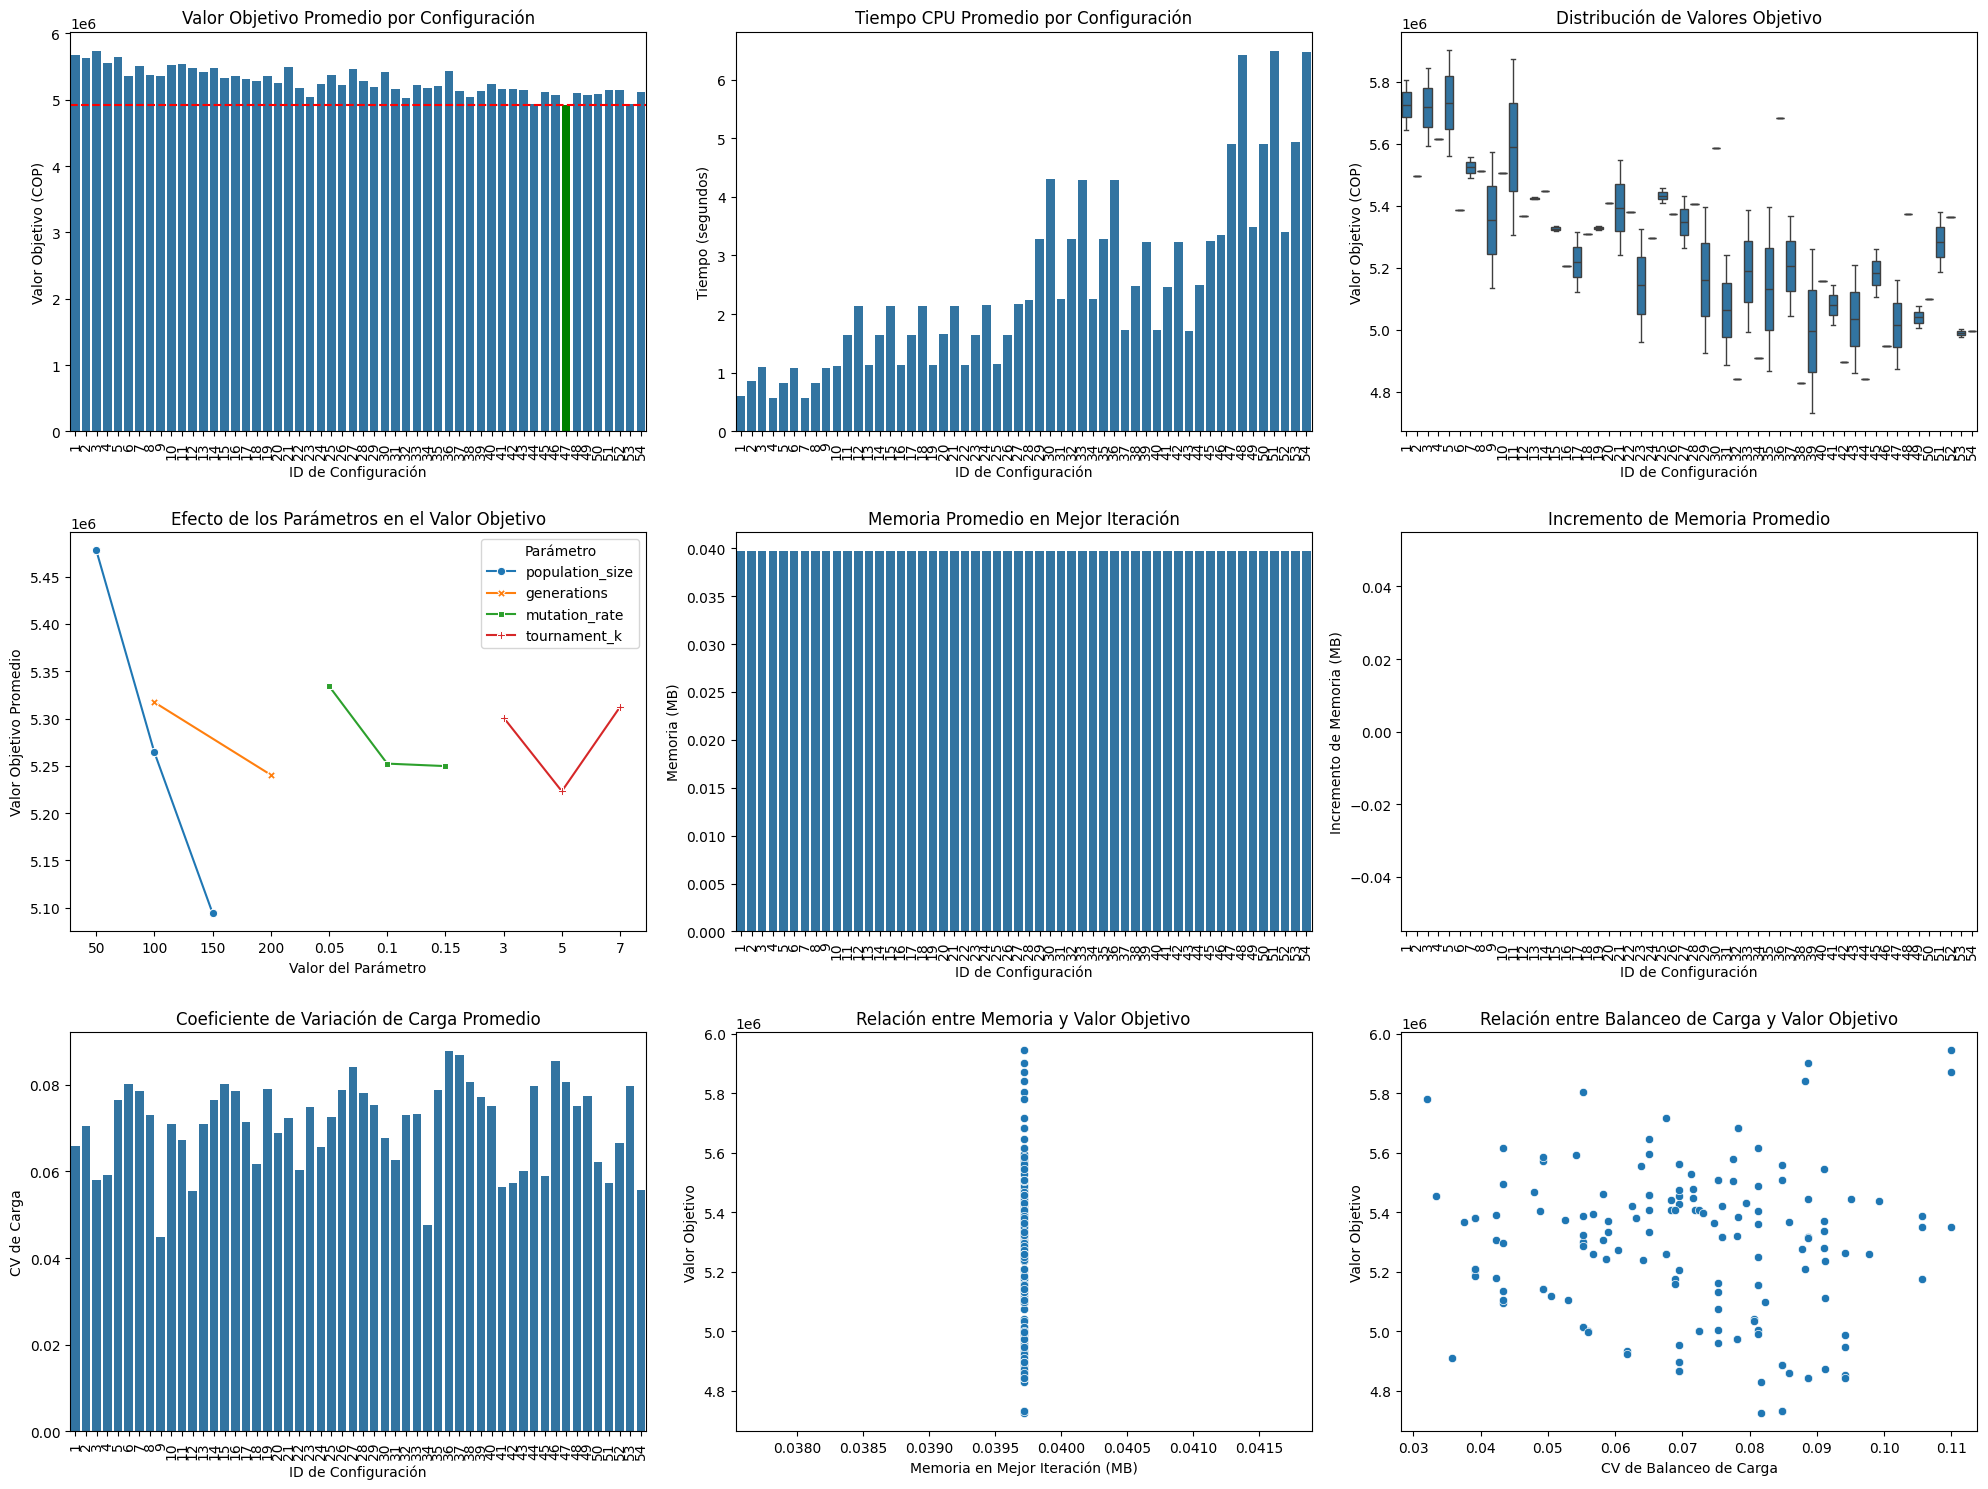

Visualizaciones guardadas en 'calibracion_graficos_Base.png'
Mejores parámetros para caso Base: {'population_size': np.float64(150.0), 'generations': np.float64(200.0), 'mutation_rate': np.float64(0.05), 'tournament_k': np.float64(5.0)}
Resultados guardados para caso Base.

--- MÉTRICAS DE BALANCEO DE CARGA PARA CASO Base ---
Cargas de vehículos: [124.0, 139.0, 114.0]
Coeficiente de variación: 0.0818
Desviación estándar de la carga: 10.27
Rango de la carga: 25.00
Solución guardada en formato solicitado: best_solution_case_Base_formatted.csv

--- CALIBRANDO PARA CASO: 2 ---
Se cargaron 9 clientes para el caso 2. Ejemplos: ['C1', 'C2', 'C3', 'C4', 'C5']
--- Calculando matriz de distancias con OSRM ---
  Distancias cargadas desde el caché GA (100 pares): Etapa3/cache/osrm_cache_ga_2.json
  No hay pares de distancias faltantes para el caso 2
Matrices de distancia y costo generadas para el caso 2. Total de entradas: 100
--- DATOS CARGADOS PARA EL CASO 2 ---

--- INICIANDO CALIBRACIÓN PARA C

Progreso de calibración:   0%|          | 0/54 [00:00<?, ?it/s]


Configuración #1/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #12 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #12 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)
Mejor iteración fue #9 con uso de memoria: 0.04 MB


Progreso de calibración:   2%|▏         | 1/54 [00:00<00:34,  1.53it/s]


Configuración #2/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #6 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #22 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:   4%|▎         | 2/54 [00:01<00:42,  1.24it/s]

Mejor iteración fue #50 con uso de memoria: 0.04 MB

Configuración #3/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #3 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #31 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:   6%|▌         | 3/54 [00:02<00:49,  1.02it/s]

Mejor iteración fue #22 con uso de memoria: 0.04 MB

Configuración #4/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #6 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #16 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:   7%|▋         | 4/54 [00:03<00:42,  1.18it/s]

Mejor iteración fue #8 con uso de memoria: 0.04 MB

Configuración #5/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #6 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #7 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:   9%|▉         | 5/54 [00:04<00:42,  1.15it/s]

Mejor iteración fue #7 con uso de memoria: 0.04 MB

Configuración #6/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #3 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #18 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  11%|█         | 6/54 [00:05<00:47,  1.01it/s]

Mejor iteración fue #25 con uso de memoria: 0.04 MB

Configuración #7/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #8 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #12 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  13%|█▎        | 7/54 [00:06<00:41,  1.14it/s]

Mejor iteración fue #8 con uso de memoria: 0.04 MB

Configuración #8/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #5 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #8 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  15%|█▍        | 8/54 [00:07<00:40,  1.13it/s]

Mejor iteración fue #16 con uso de memoria: 0.04 MB

Configuración #9/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #3 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #14 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  17%|█▋        | 9/54 [00:08<00:44,  1.02it/s]

Mejor iteración fue #17 con uso de memoria: 0.04 MB

Configuración #10/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #12 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #12 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  19%|█▊        | 10/54 [00:09<00:46,  1.07s/it]

Mejor iteración fue #9 con uso de memoria: 0.04 MB

Configuración #11/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #6 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #22 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  20%|██        | 11/54 [00:11<00:55,  1.29s/it]

Mejor iteración fue #50 con uso de memoria: 0.04 MB

Configuración #12/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #3 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #31 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  22%|██▏       | 12/54 [00:13<01:07,  1.61s/it]

Mejor iteración fue #22 con uso de memoria: 0.04 MB

Configuración #13/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #6 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #16 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  24%|██▍       | 13/54 [00:14<01:01,  1.51s/it]

Mejor iteración fue #8 con uso de memoria: 0.04 MB

Configuración #14/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #6 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #7 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  26%|██▌       | 14/54 [00:16<01:03,  1.60s/it]

Mejor iteración fue #7 con uso de memoria: 0.04 MB

Configuración #15/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #3 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #18 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  28%|██▊       | 15/54 [00:19<01:11,  1.83s/it]

Mejor iteración fue #25 con uso de memoria: 0.04 MB

Configuración #16/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #8 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #12 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  30%|██▉       | 16/54 [00:20<01:03,  1.66s/it]

Mejor iteración fue #8 con uso de memoria: 0.04 MB

Configuración #17/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #5 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #8 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  31%|███▏      | 17/54 [00:22<01:03,  1.71s/it]

Mejor iteración fue #16 con uso de memoria: 0.04 MB

Configuración #18/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #3 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #14 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  33%|███▎      | 18/54 [00:24<01:08,  1.91s/it]

Mejor iteración fue #17 con uso de memoria: 0.04 MB

Configuración #19/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #4 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #9 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  35%|███▌      | 19/54 [00:25<00:59,  1.71s/it]

Mejor iteración fue #9 con uso de memoria: 0.04 MB

Configuración #20/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #3 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #4 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  37%|███▋      | 20/54 [00:27<00:59,  1.74s/it]

Mejor iteración fue #4 con uso de memoria: 0.04 MB

Configuración #21/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #5 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #10 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  39%|███▉      | 21/54 [00:29<01:03,  1.93s/it]

Mejor iteración fue #4 con uso de memoria: 0.04 MB

Configuración #22/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #10 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #10 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  41%|████      | 22/54 [00:31<00:55,  1.73s/it]

Mejor iteración fue #8 con uso de memoria: 0.04 MB

Configuración #23/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #5 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #8 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  43%|████▎     | 23/54 [00:33<00:55,  1.78s/it]

Mejor iteración fue #18 con uso de memoria: 0.04 MB

Configuración #24/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #4 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #6 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  44%|████▍     | 24/54 [00:35<00:58,  1.96s/it]

Mejor iteración fue #20 con uso de memoria: 0.04 MB

Configuración #25/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #8 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #9 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  46%|████▋     | 25/54 [00:36<00:50,  1.76s/it]

Mejor iteración fue #29 con uso de memoria: 0.04 MB

Configuración #26/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #6 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #7 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  48%|████▊     | 26/54 [00:38<00:49,  1.78s/it]

Mejor iteración fue #8 con uso de memoria: 0.04 MB

Configuración #27/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #10 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #10 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  50%|█████     | 27/54 [00:41<00:52,  1.96s/it]

Mejor iteración fue #10 con uso de memoria: 0.04 MB

Configuración #28/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #4 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #9 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  52%|█████▏    | 28/54 [00:43<00:55,  2.12s/it]

Mejor iteración fue #9 con uso de memoria: 0.04 MB

Configuración #29/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #3 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #4 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  54%|█████▎    | 29/54 [00:47<01:04,  2.59s/it]

Mejor iteración fue #4 con uso de memoria: 0.04 MB

Configuración #30/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #5 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #10 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  56%|█████▌    | 30/54 [00:51<01:17,  3.24s/it]

Mejor iteración fue #4 con uso de memoria: 0.04 MB

Configuración #31/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #10 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #10 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  57%|█████▋    | 31/54 [00:54<01:09,  3.03s/it]

Mejor iteración fue #8 con uso de memoria: 0.04 MB

Configuración #32/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #5 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #8 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  59%|█████▉    | 32/54 [00:58<01:10,  3.22s/it]

Mejor iteración fue #18 con uso de memoria: 0.04 MB

Configuración #33/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #4 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #6 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  61%|██████    | 33/54 [01:03<01:17,  3.71s/it]

Mejor iteración fue #20 con uso de memoria: 0.04 MB

Configuración #34/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #8 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #9 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  63%|██████▎   | 34/54 [01:05<01:07,  3.38s/it]

Mejor iteración fue #29 con uso de memoria: 0.04 MB

Configuración #35/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #6 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #7 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  65%|██████▍   | 35/54 [01:09<01:05,  3.47s/it]

Mejor iteración fue #8 con uso de memoria: 0.04 MB

Configuración #36/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #10 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #10 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  67%|██████▋   | 36/54 [01:14<01:09,  3.87s/it]

Mejor iteración fue #10 con uso de memoria: 0.04 MB

Configuración #37/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #8 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #15 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  69%|██████▊   | 37/54 [01:16<00:55,  3.29s/it]

Mejor iteración fue #4 con uso de memoria: 0.04 MB

Configuración #38/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #3 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #6 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  70%|███████   | 38/54 [01:18<00:50,  3.13s/it]

Mejor iteración fue #13 con uso de memoria: 0.04 MB

Configuración #39/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #2 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #7 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  72%|███████▏  | 39/54 [01:22<00:49,  3.27s/it]

Mejor iteración fue #6 con uso de memoria: 0.04 MB

Configuración #40/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #7 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #7 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  74%|███████▍  | 40/54 [01:24<00:40,  2.86s/it]

Mejor iteración fue #4 con uso de memoria: 0.04 MB

Configuración #41/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #7 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #5 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  76%|███████▌  | 41/54 [01:27<00:37,  2.85s/it]

Mejor iteración fue #7 con uso de memoria: 0.04 MB

Configuración #42/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #5 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #5 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  78%|███████▊  | 42/54 [01:30<00:37,  3.14s/it]

Mejor iteración fue #7 con uso de memoria: 0.04 MB

Configuración #43/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #5 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #17 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  80%|███████▉  | 43/54 [01:32<00:30,  2.78s/it]

Mejor iteración fue #26 con uso de memoria: 0.04 MB

Configuración #44/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #7 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #9 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  81%|████████▏ | 44/54 [01:35<00:27,  2.78s/it]

Mejor iteración fue #14 con uso de memoria: 0.04 MB

Configuración #45/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #2 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #7 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  83%|████████▎ | 45/54 [01:39<00:27,  3.07s/it]

Mejor iteración fue #6 con uso de memoria: 0.04 MB

Configuración #46/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #8 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #15 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  85%|████████▌ | 46/54 [01:43<00:26,  3.32s/it]

Mejor iteración fue #4 con uso de memoria: 0.04 MB

Configuración #47/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #3 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #6 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  87%|████████▋ | 47/54 [01:48<00:28,  4.01s/it]

Mejor iteración fue #13 con uso de memoria: 0.04 MB

Configuración #48/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #2 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #7 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  89%|████████▉ | 48/54 [01:56<00:29,  4.93s/it]

Mejor iteración fue #6 con uso de memoria: 0.04 MB

Configuración #49/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #7 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #7 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  91%|█████████ | 49/54 [01:59<00:22,  4.59s/it]

Mejor iteración fue #4 con uso de memoria: 0.04 MB

Configuración #50/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #7 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #5 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  93%|█████████▎| 50/54 [02:05<00:19,  4.91s/it]

Mejor iteración fue #7 con uso de memoria: 0.04 MB

Configuración #51/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #5 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #5 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  94%|█████████▍| 51/54 [02:12<00:16,  5.61s/it]

Mejor iteración fue #7 con uso de memoria: 0.04 MB

Configuración #52/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #5 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #17 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  96%|█████████▋| 52/54 [02:16<00:10,  5.08s/it]

Mejor iteración fue #26 con uso de memoria: 0.04 MB

Configuración #53/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #7 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #9 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  98%|█████████▊| 53/54 [02:22<00:05,  5.24s/it]

Mejor iteración fue #14 con uso de memoria: 0.04 MB

Configuración #54/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #2 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #7 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración: 100%|██████████| 54/54 [02:29<00:00,  2.77s/it]

Mejor iteración fue #6 con uso de memoria: 0.04 MB

RESULTADOS DE LA CALIBRACIÓN

Mejor configuración encontrada:
  Config #7.0
  population_size: 50.0
  generations: 100.0
  mutation_rate: 0.15
  tournament_k: 3.0

Estadísticas de la mejor configuración:
  Valor objetivo promedio: 2,079,151.47
  Desviación estándar: 0.00
  Mejor valor: 2,079,151.47
  Peor valor: 2,079,151.47
  Tiempo CPU promedio: 0.21 segundos
  Vehículos promedio: 1.00
  Distancia total promedio: 100.44 km
  Incremento de memoria promedio: 0.00 MB
  Memoria en mejor iteración promedio: 0.04 MB
  Coeficiente de variación de carga promedio: 0.0000
  Desviación estándar de carga promedio: 0.00
  Rango de carga promedio: 0.00

Resultados guardados en 'calibracion_resultados_2.csv' y 'calibracion_estadisticas_2.csv'


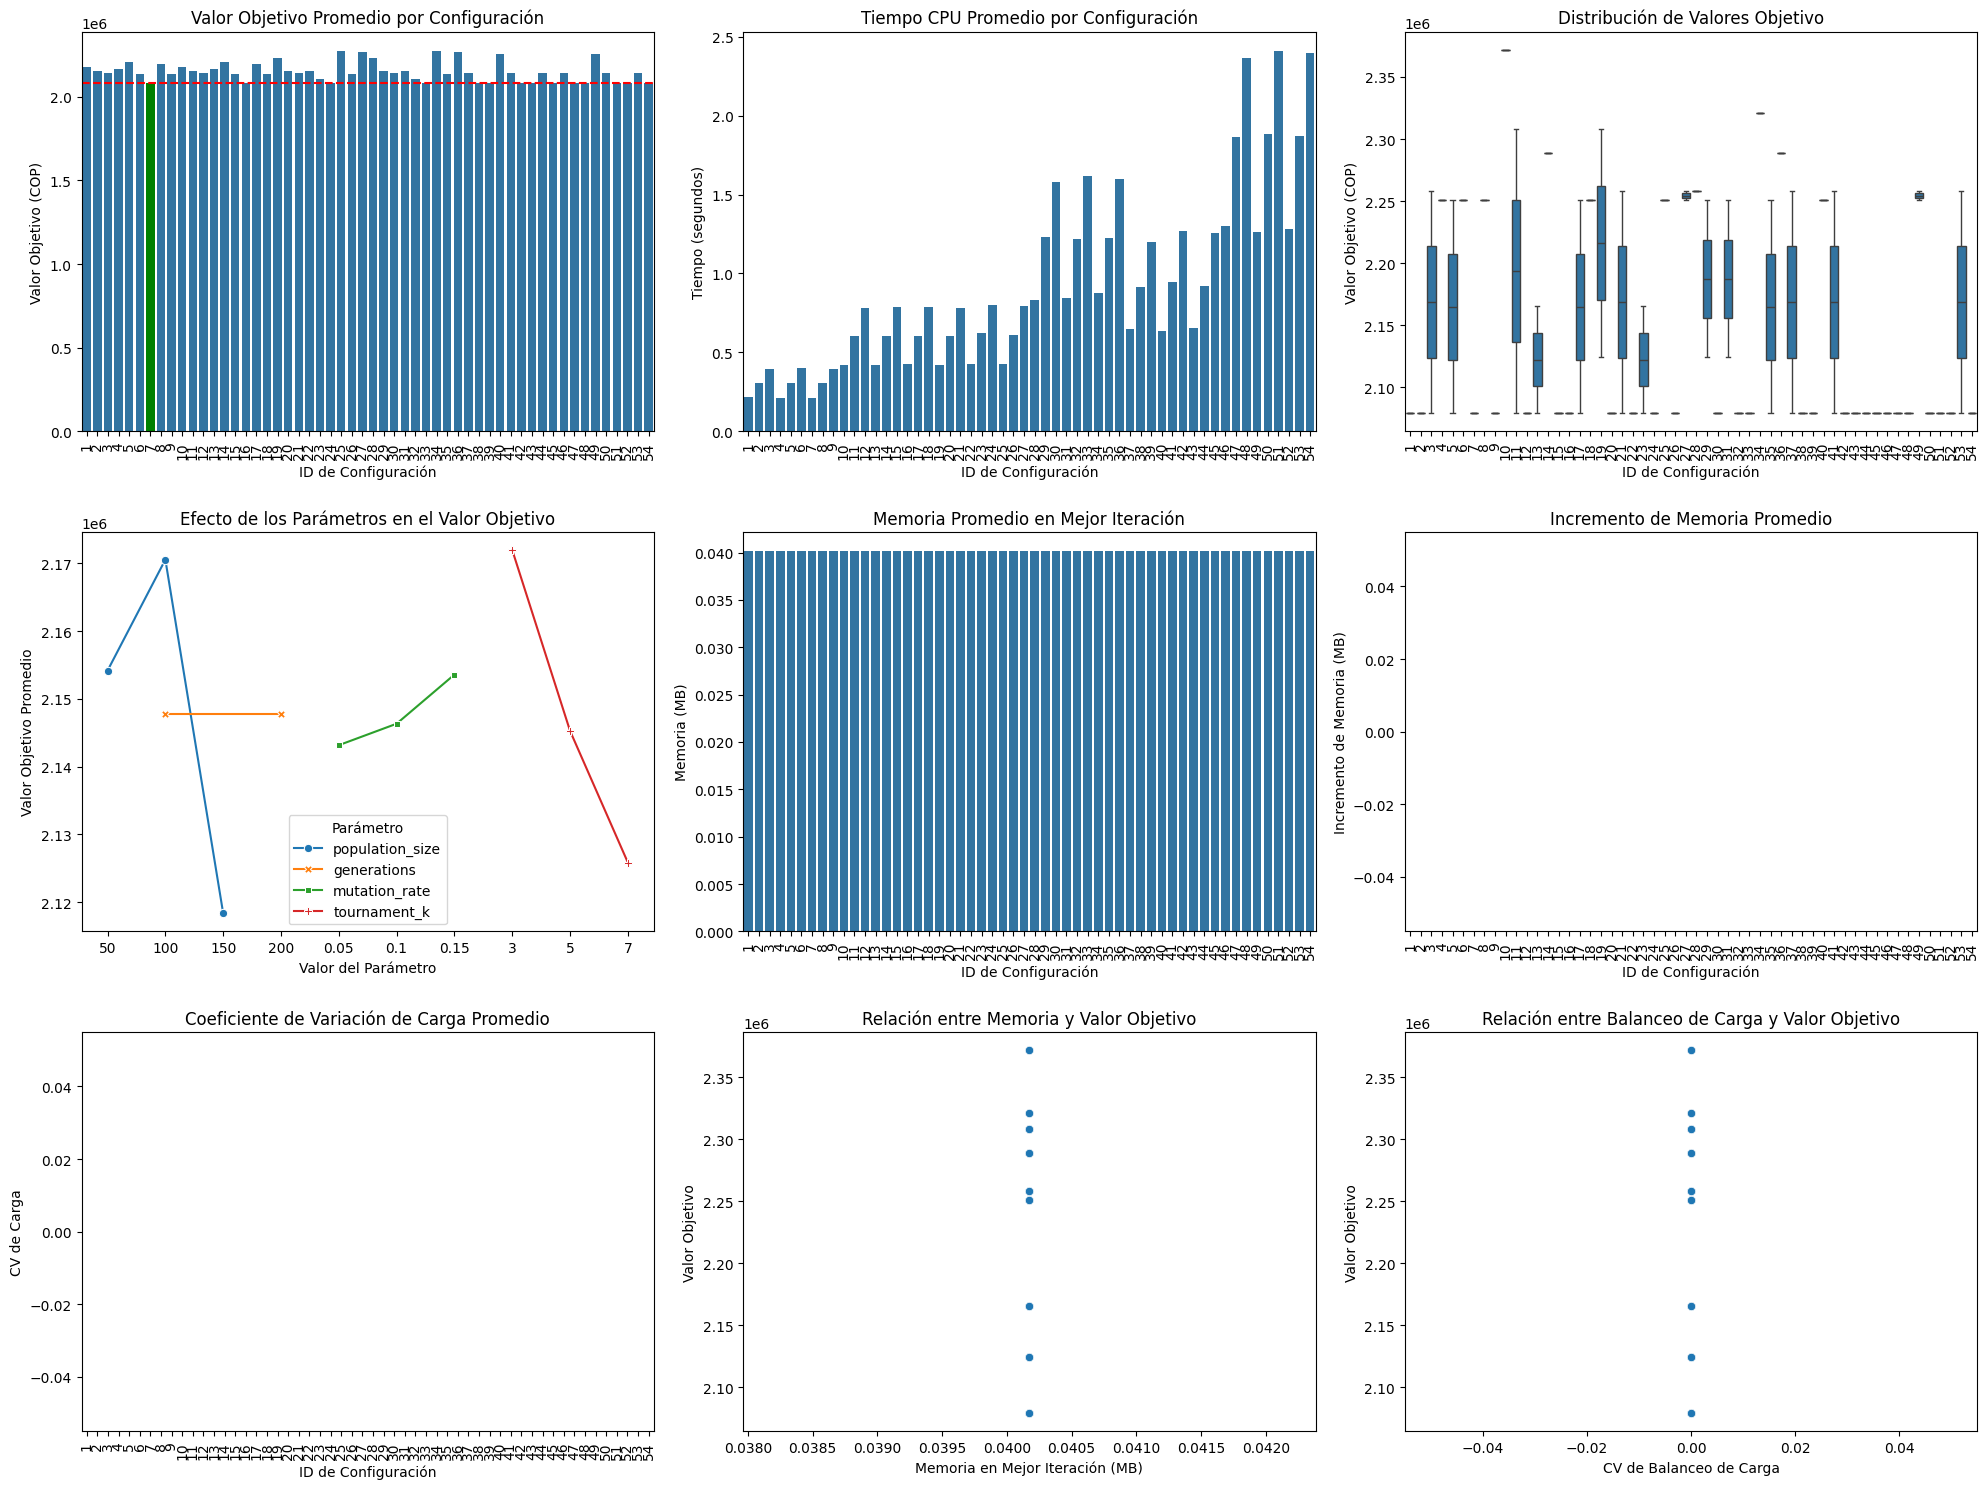

Visualizaciones guardadas en 'calibracion_graficos_2.png'
Mejores parámetros para caso 2: {'population_size': np.float64(50.0), 'generations': np.float64(100.0), 'mutation_rate': np.float64(0.15), 'tournament_k': np.float64(3.0)}
Resultados guardados para caso 2.

--- MÉTRICAS DE BALANCEO DE CARGA PARA CASO 2 ---
Cargas de vehículos: [101.0]
Coeficiente de variación: 0.0000
Desviación estándar de la carga: 0.00
Rango de la carga: 0.00
Solución guardada en formato solicitado: best_solution_case_2_formatted.csv

--- CALIBRANDO PARA CASO: 3 ---
Se cargaron 90 clientes para el caso 3. Ejemplos: ['C1', 'C2', 'C3', 'C4', 'C5']
--- Calculando matriz de distancias con OSRM ---
  Distancias cargadas desde el caché GA (8281 pares): Etapa3/cache/osrm_cache_ga_3.json
  No hay pares de distancias faltantes para el caso 3
Matrices de distancia y costo generadas para el caso 3. Total de entradas: 8281
--- DATOS CARGADOS PARA EL CASO 3 ---

--- INICIANDO CALIBRACIÓN PARA CASO: 3 ---

Se cargaron 90 cl

Progreso de calibración:   0%|          | 0/54 [00:00<?, ?it/s]


Configuración #1/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #98 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #97 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:   2%|▏         | 1/54 [00:06<06:10,  6.98s/it]

Mejor iteración fue #100 con uso de memoria: 0.04 MB

Configuración #2/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #79 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:   4%|▎         | 2/54 [00:16<07:30,  8.66s/it]

Mejor iteración fue #99 con uso de memoria: 0.04 MB

Configuración #3/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #95 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #92 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:   6%|▌         | 3/54 [00:29<08:55, 10.51s/it]

Mejor iteración fue #100 con uso de memoria: 0.04 MB

Configuración #4/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #99 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #88 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:   7%|▋         | 4/54 [00:36<07:35,  9.11s/it]

Mejor iteración fue #98 con uso de memoria: 0.04 MB

Configuración #5/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #94 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:   9%|▉         | 5/54 [00:46<07:43,  9.46s/it]

Mejor iteración fue #97 con uso de memoria: 0.04 MB

Configuración #6/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #97 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  11%|█         | 6/54 [00:59<08:32, 10.67s/it]

Mejor iteración fue #100 con uso de memoria: 0.04 MB

Configuración #7/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #97 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  13%|█▎        | 7/54 [01:06<07:26,  9.49s/it]

Mejor iteración fue #82 con uso de memoria: 0.04 MB

Configuración #8/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #93 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #98 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  15%|█▍        | 8/54 [01:16<07:25,  9.68s/it]

Mejor iteración fue #96 con uso de memoria: 0.04 MB

Configuración #9/54: {'population_size': 50, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #94 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  17%|█▋        | 9/54 [01:29<08:05, 10.79s/it]

Mejor iteración fue #100 con uso de memoria: 0.04 MB

Configuración #10/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #199 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #191 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  19%|█▊        | 10/54 [01:43<08:33, 11.68s/it]

Mejor iteración fue #196 con uso de memoria: 0.04 MB

Configuración #11/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #199 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #195 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  20%|██        | 11/54 [02:03<10:14, 14.29s/it]

Mejor iteración fue #180 con uso de memoria: 0.04 MB

Configuración #12/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #199 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #189 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  22%|██▏       | 12/54 [02:29<12:28, 17.83s/it]

Mejor iteración fue #200 con uso de memoria: 0.04 MB

Configuración #13/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #197 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #196 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  24%|██▍       | 13/54 [02:43<11:20, 16.61s/it]

Mejor iteración fue #196 con uso de memoria: 0.04 MB

Configuración #14/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #199 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #190 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  26%|██▌       | 14/54 [03:03<11:44, 17.61s/it]

Mejor iteración fue #191 con uso de memoria: 0.04 MB

Configuración #15/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #200 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #199 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  28%|██▊       | 15/54 [03:29<13:00, 20.01s/it]

Mejor iteración fue #200 con uso de memoria: 0.04 MB

Configuración #16/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #198 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #188 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  30%|██▉       | 16/54 [03:42<11:25, 18.03s/it]

Mejor iteración fue #187 con uso de memoria: 0.04 MB

Configuración #17/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #196 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #193 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  31%|███▏      | 17/54 [04:01<11:21, 18.43s/it]

Mejor iteración fue #184 con uso de memoria: 0.04 MB

Configuración #18/54: {'population_size': 50, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #190 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #192 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  33%|███▎      | 18/54 [04:27<12:17, 20.47s/it]

Mejor iteración fue #200 con uso de memoria: 0.04 MB

Configuración #19/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #98 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #99 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  35%|███▌      | 19/54 [04:40<10:46, 18.48s/it]

Mejor iteración fue #99 con uso de memoria: 0.04 MB

Configuración #20/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #93 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #99 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  37%|███▋      | 20/54 [05:00<10:37, 18.76s/it]

Mejor iteración fue #99 con uso de memoria: 0.04 MB

Configuración #21/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  39%|███▉      | 21/54 [05:25<11:26, 20.80s/it]

Mejor iteración fue #100 con uso de memoria: 0.04 MB

Configuración #22/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  41%|████      | 22/54 [05:39<09:58, 18.71s/it]

Mejor iteración fue #100 con uso de memoria: 0.04 MB

Configuración #23/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  43%|████▎     | 23/54 [05:59<09:47, 18.96s/it]

Mejor iteración fue #100 con uso de memoria: 0.04 MB

Configuración #24/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #96 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #96 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  44%|████▍     | 24/54 [06:24<10:27, 20.91s/it]

Mejor iteración fue #97 con uso de memoria: 0.04 MB

Configuración #25/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #71 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  46%|████▋     | 25/54 [06:38<09:04, 18.78s/it]

Mejor iteración fue #100 con uso de memoria: 0.04 MB

Configuración #26/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #99 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  48%|████▊     | 26/54 [06:58<08:52, 19.02s/it]

Mejor iteración fue #100 con uso de memoria: 0.04 MB

Configuración #27/54: {'population_size': 100, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #96 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  50%|█████     | 27/54 [07:23<09:26, 20.96s/it]

Mejor iteración fue #100 con uso de memoria: 0.04 MB

Configuración #28/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #196 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #198 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  52%|█████▏    | 28/54 [07:50<09:53, 22.82s/it]

Mejor iteración fue #192 con uso de memoria: 0.04 MB

Configuración #29/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #200 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #175 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  54%|█████▎    | 29/54 [08:29<11:30, 27.61s/it]

Mejor iteración fue #182 con uso de memoria: 0.04 MB

Configuración #30/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #195 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #191 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  56%|█████▌    | 30/54 [09:20<13:47, 34.48s/it]

Mejor iteración fue #185 con uso de memoria: 0.04 MB

Configuración #31/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #200 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #198 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  57%|█████▋    | 31/54 [09:47<12:21, 32.25s/it]

Mejor iteración fue #191 con uso de memoria: 0.04 MB

Configuración #32/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #199 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #198 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  59%|█████▉    | 32/54 [10:25<12:32, 34.19s/it]

Mejor iteración fue #200 con uso de memoria: 0.04 MB

Configuración #33/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #195 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #200 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  61%|██████    | 33/54 [11:16<13:41, 39.12s/it]

Mejor iteración fue #200 con uso de memoria: 0.04 MB

Configuración #34/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #198 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #199 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  63%|██████▎   | 34/54 [11:43<11:49, 35.47s/it]

Mejor iteración fue #200 con uso de memoria: 0.04 MB

Configuración #35/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #198 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #200 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  65%|██████▍   | 35/54 [12:21<11:31, 36.38s/it]

Mejor iteración fue #199 con uso de memoria: 0.04 MB

Configuración #36/54: {'population_size': 100, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #196 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #200 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  67%|██████▋   | 36/54 [13:12<12:12, 40.68s/it]

Mejor iteración fue #199 con uso de memoria: 0.04 MB

Configuración #37/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #99 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #99 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  69%|██████▊   | 37/54 [13:33<09:50, 34.74s/it]

Mejor iteración fue #100 con uso de memoria: 0.04 MB

Configuración #38/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #99 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #96 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  70%|███████   | 38/54 [14:03<08:53, 33.31s/it]

Mejor iteración fue #98 con uso de memoria: 0.04 MB

Configuración #39/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #97 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #97 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  72%|███████▏  | 39/54 [14:42<08:44, 34.97s/it]

Mejor iteración fue #98 con uso de memoria: 0.04 MB

Configuración #40/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  74%|███████▍  | 40/54 [15:03<07:10, 30.74s/it]

Mejor iteración fue #98 con uso de memoria: 0.04 MB

Configuración #41/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #99 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  76%|███████▌  | 41/54 [15:32<06:33, 30.25s/it]

Mejor iteración fue #100 con uso de memoria: 0.04 MB

Configuración #42/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #98 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #98 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  78%|███████▊  | 42/54 [16:10<06:32, 32.74s/it]

Mejor iteración fue #98 con uso de memoria: 0.04 MB

Configuración #43/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #99 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  80%|███████▉  | 43/54 [16:31<05:21, 29.24s/it]

Mejor iteración fue #54 con uso de memoria: 0.04 MB

Configuración #44/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #99 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #100 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  81%|████████▏ | 44/54 [17:02<04:56, 29.65s/it]

Mejor iteración fue #100 con uso de memoria: 0.04 MB

Configuración #45/54: {'population_size': 150, 'generations': 100, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #98 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #98 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  83%|████████▎ | 45/54 [17:41<04:53, 32.56s/it]

Mejor iteración fue #98 con uso de memoria: 0.04 MB

Configuración #46/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #195 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #198 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  85%|████████▌ | 46/54 [18:23<04:41, 35.20s/it]

Mejor iteración fue #200 con uso de memoria: 0.04 MB

Configuración #47/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #195 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #199 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  87%|████████▋ | 47/54 [19:24<05:01, 43.04s/it]

Mejor iteración fue #199 con uso de memoria: 0.04 MB

Configuración #48/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.05, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #191 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #197 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  89%|████████▉ | 48/54 [20:44<05:24, 54.05s/it]

Mejor iteración fue #200 con uso de memoria: 0.04 MB

Configuración #49/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #196 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #200 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  91%|█████████ | 49/54 [21:26<04:11, 50.34s/it]

Mejor iteración fue #195 con uso de memoria: 0.04 MB

Configuración #50/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #199 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #198 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  93%|█████████▎| 50/54 [22:25<03:32, 53.07s/it]

Mejor iteración fue #200 con uso de memoria: 0.04 MB

Configuración #51/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.1, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #200 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #194 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  94%|█████████▍| 51/54 [23:42<03:00, 60.24s/it]

Mejor iteración fue #198 con uso de memoria: 0.04 MB

Configuración #52/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 3}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #200 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #196 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  96%|█████████▋| 52/54 [24:25<01:50, 55.15s/it]

Mejor iteración fue #199 con uso de memoria: 0.04 MB

Configuración #53/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 5}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #198 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #200 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración:  98%|█████████▊| 53/54 [25:24<00:56, 56.36s/it]

Mejor iteración fue #200 con uso de memoria: 0.04 MB

Configuración #54/54: {'population_size': 150, 'generations': 200, 'mutation_rate': 0.15, 'tournament_k': 7}
  Corrida 1/3 (semilla: 42)
Mejor iteración fue #195 con uso de memoria: 0.04 MB
  Corrida 2/3 (semilla: 123)
Mejor iteración fue #199 con uso de memoria: 0.04 MB
  Corrida 3/3 (semilla: 7890)


Progreso de calibración: 100%|██████████| 54/54 [26:42<00:00, 29.68s/it]

Mejor iteración fue #195 con uso de memoria: 0.04 MB

RESULTADOS DE LA CALIBRACIÓN

Mejor configuración encontrada:
  Config #50.0
  population_size: 150.0
  generations: 200.0
  mutation_rate: 0.1
  tournament_k: 5.0

Estadísticas de la mejor configuración:
  Valor objetivo promedio: 18,996,698.43
  Desviación estándar: 906,204.71
  Mejor valor: 18,237,329.28
  Peor valor: 19,999,861.83
  Tiempo CPU promedio: 19.81 segundos
  Vehículos promedio: 10.00
  Distancia total promedio: 917.71 km
  Incremento de memoria promedio: -0.04 MB
  Memoria en mejor iteración promedio: 0.04 MB
  Coeficiente de variación de carga promedio: 0.2318
  Desviación estándar de carga promedio: 24.64
  Rango de carga promedio: 87.00

Resultados guardados en 'calibracion_resultados_3.csv' y 'calibracion_estadisticas_3.csv'


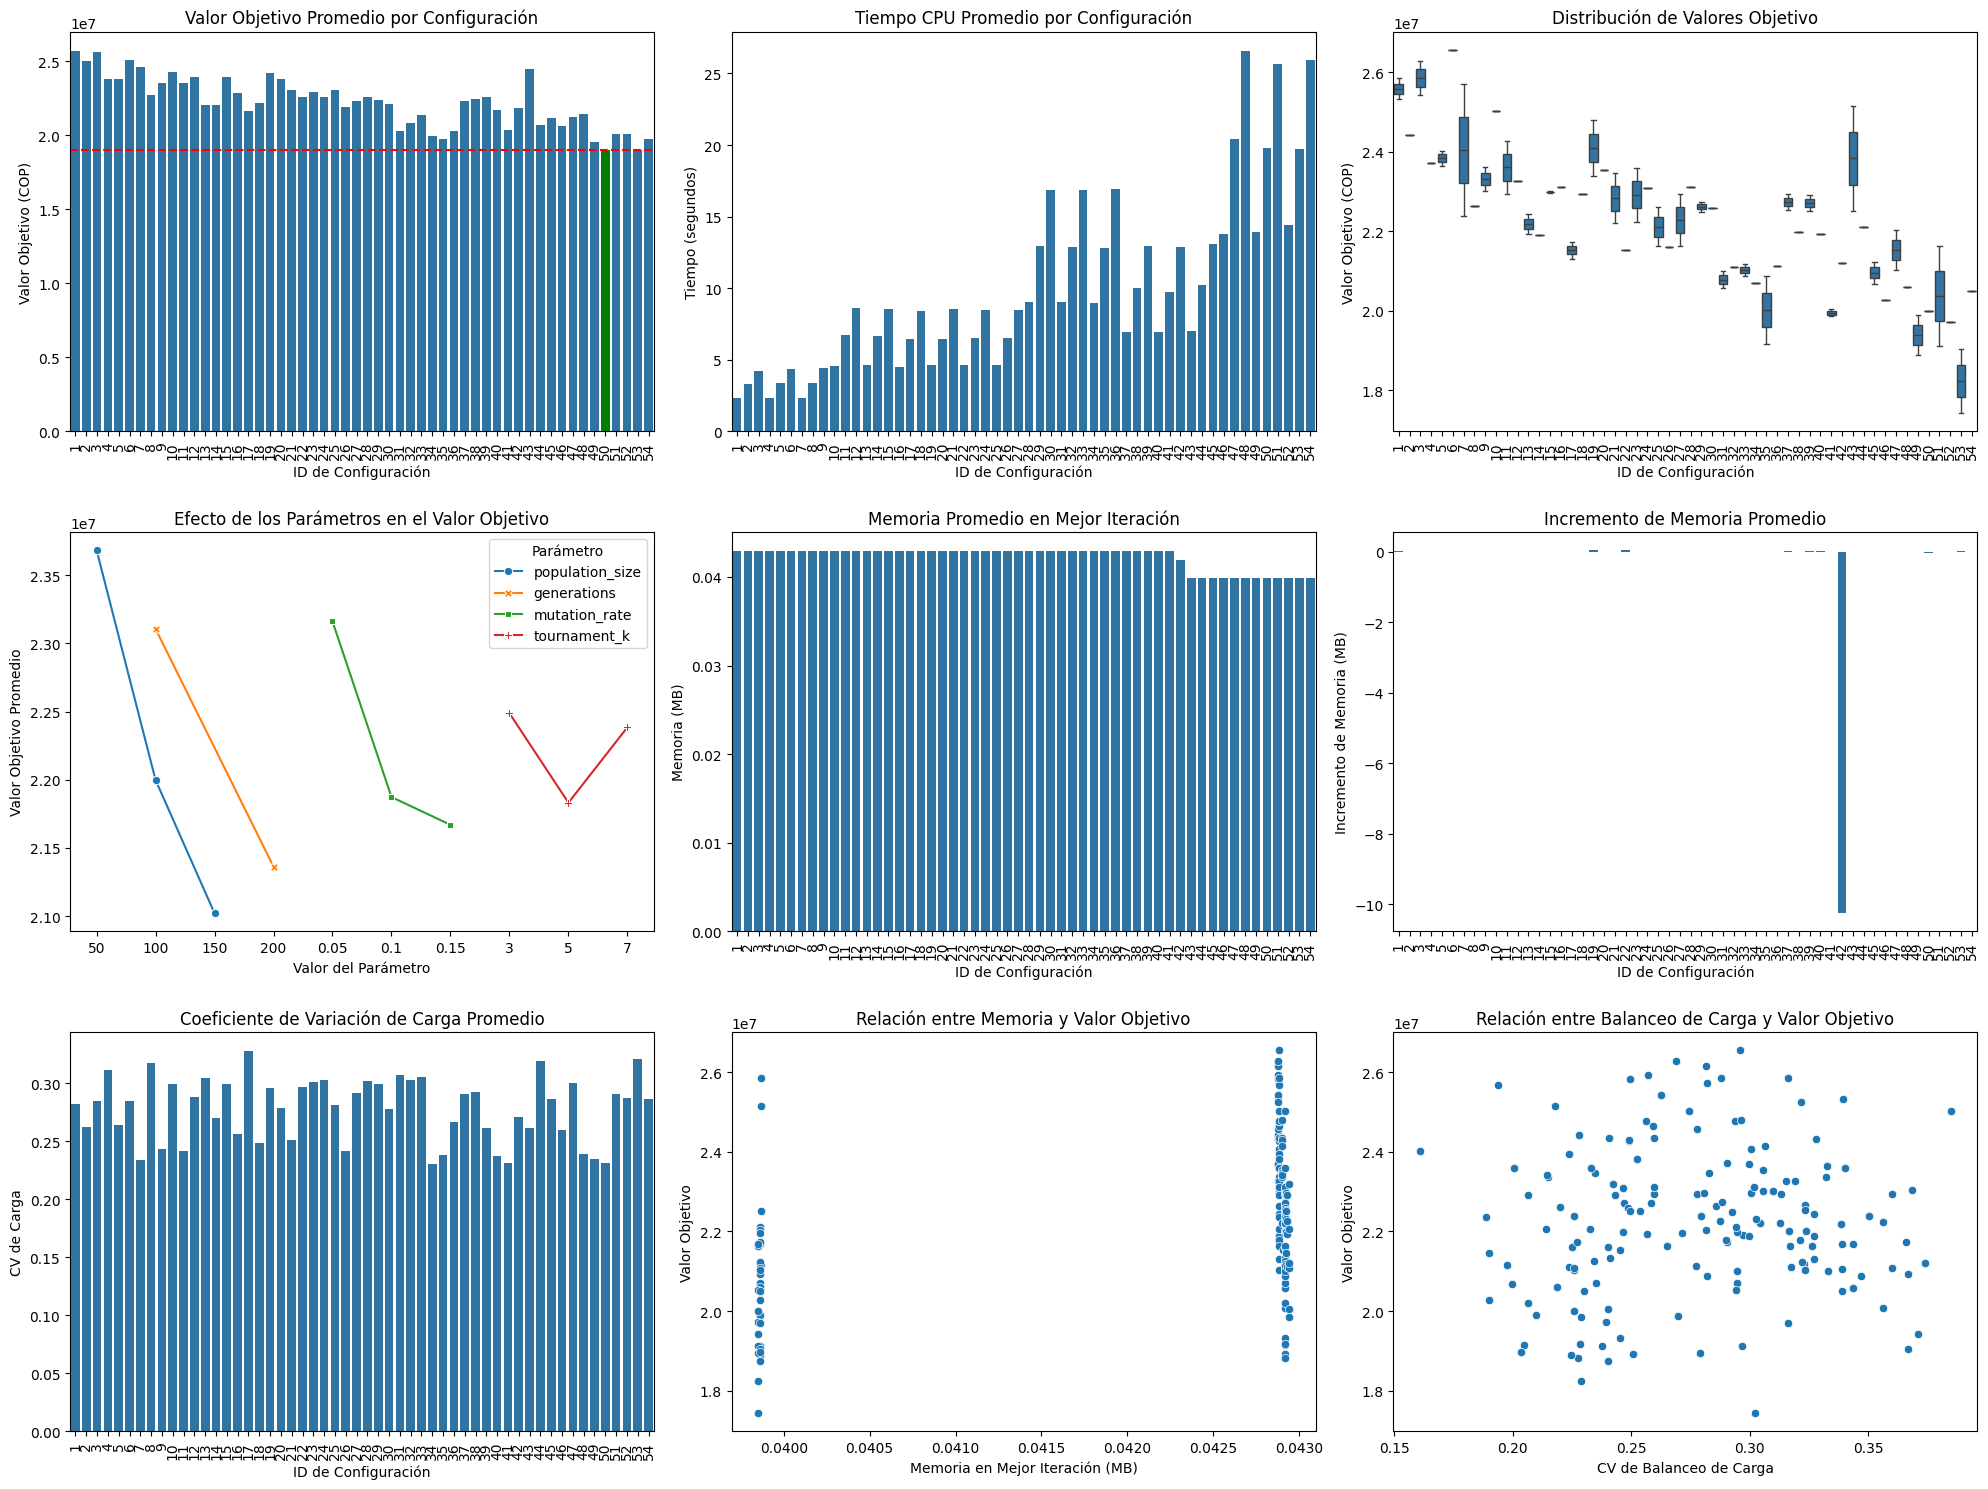

Visualizaciones guardadas en 'calibracion_graficos_3.png'
Mejores parámetros para caso 3: {'population_size': np.float64(150.0), 'generations': np.float64(200.0), 'mutation_rate': np.float64(0.1), 'tournament_k': np.float64(5.0)}
Resultados guardados para caso 3.

--- MÉTRICAS DE BALANCEO DE CARGA PARA CASO 3 ---
Cargas de vehículos: [132.0, 132.0, 106.0, 155.0, 109.0, 108.0, 120.0, 69.0, 96.0, 36.0]
Coeficiente de variación: 0.3024
Desviación estándar de la carga: 32.14
Rango de la carga: 119.00
Solución guardada en formato solicitado: best_solution_case_3_formatted.csv


In [188]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import product
from tqdm import tqdm
import random
import csv
import psutil
import os

# Guarda la solución en el formato que necesitamos
def save_solution_in_requested_format(routes, depot_id, filename="best_solution_formatted.csv"):
    with open(filename, 'w', newline='') as csvfile:
        writer = csv.writer(csvfile)
        writer.writerow(['VehicleId', 'DepotId', 'InitialLoad', 'RouteSequence', 'ClientsServed', 
                        'DemandsSatisfied', 'TotalDistance', 'TotalTime', 'FuelCost'])
        
        for i, (vehicle_idx, route) in enumerate(routes):
            if not route or len(route) <= 2:
                continue
                
            vehicle_id = f"VEH{(i+1):03d}"
            depot_id_str = depot_id
            
            clients_in_route = [node for node in route if node != depot_id]
            initial_load = sum(GA_DATA["client_demands"].get(client, 0) for client in clients_in_route)
            
            route_sequence = " - ".join(route)
            
            clients_served = len(clients_in_route)
            
            demands_satisfied = " - ".join([str(int(GA_DATA["client_demands"].get(client, 0))) 
                                      for client in clients_in_route])
            
            total_distance = 0
            for k_idx in range(len(route) - 1):
                u, v = route[k_idx], route[k_idx+1]
                total_distance += GA_DATA["distance_matrix"].get((u, v), 0)
            
            avg_time_per_km = 2.5
            total_time = total_distance * avg_time_per_km
            
            fuel_cost = int(total_distance * C_KM)
            
            writer.writerow([
                vehicle_id,
                depot_id_str,
                int(initial_load),
                route_sequence,
                clients_served,
                demands_satisfied,
                f"{total_distance:.1f}",
                f"{total_time:.1f}",
                fuel_cost
            ])
    
    print(f"Solución guardada en formato solicitado: {filename}")

# Calcula métricas de balance de carga para las cargas de los vehículos para el análisis
def calculate_load_balance_metrics(loads):
    metrics = {}
    loads_array = np.array(loads)
    if len(loads_array) == 0:
        metrics['load_balance_std'] = np.nan
        metrics['load_balance_range'] = np.nan
        metrics['load_balance_cv'] = np.nan
        return metrics
    
    mean_load = np.mean(loads_array)
    std_load = np.std(loads_array)
    range_load = np.max(loads_array) - np.min(loads_array)
    cv_load = std_load / mean_load if mean_load != 0 else np.nan
    
    metrics['load_balance_std'] = std_load
    metrics['load_balance_range'] = range_load
    metrics['load_balance_cv'] = cv_load
    return metrics

# Calcula la carga de los vehiculos a partir de las rutas generadas
def calculate_vehicle_loads(routes, ga_data):
    vehicle_loads = []
    for vehicle_idx, route in routes:
        clients_in_route = [node for node in route if node != ga_data["depot_id"]]
        total_load = sum(ga_data["client_demands"].get(client, 0) for client in clients_in_route)
        vehicle_loads.append(total_load)
    return vehicle_loads


# Obtiene el uso de memoria actual del proceso
def get_memory_usage():
    process = psutil.Process(os.getpid())
    memory_info = process.memory_info()
    return memory_info.rss / 1024 / 1024


# Ejecuta el algoritmo genético con seguimiento del uso de memoria
def run_genetic_algorithm_cvrp_with_memory_tracking(data, pop_size, generations, mutation_rate, tournament_k):
    client_ids_list = data["client_ids"]
    
    population = generate_initial_population(pop_size, client_ids_list)
    best_overall_fitness = float('inf')
    best_overall_chromosome = None
    generation_log = []
    best_iteration_memory = 0
    best_iteration_number = 0
     
    for gen in range(generations):
        gen_start_memory = get_memory_usage()
        
        fitness_values = [calculate_cvrp_fitness(ind, data) for ind in population]
        
        min_fitness_current_gen = min(fitness_values)
        best_chromosome_current_gen = population[fitness_values.index(min_fitness_current_gen)]
        
        # Actualizar el mejor cromosoma y fitness si es necesario
        if min_fitness_current_gen < best_overall_fitness:
            best_overall_fitness = min_fitness_current_gen
            best_overall_chromosome = list(best_chromosome_current_gen)
            best_iteration_memory = get_memory_usage()
            best_iteration_number = gen + 1
        
        avg_fitness_current_gen = sum(fitness_values) / len(fitness_values)
        generation_log.append((gen + 1, best_overall_fitness, avg_fitness_current_gen))
        
        parents = selection_by_tournament(population, calculate_cvrp_fitness, data, k=tournament_k)
        
        next_population = []
        for i in range(0, pop_size, 2):
            if i + 1 < len(parents):
                p1 = parents[i]
                p2 = parents[i+1]
                child1 = order_crossover(p1, p2)
                child2 = order_crossover(p2, p1)
                child1_mutated = swap_mutation(child1, mutation_rate)
                child2_mutated = swap_mutation(child2, mutation_rate)
                next_population.append(child1_mutated)
                next_population.append(child2_mutated)
            elif i < len(parents):
                next_population.append(parents[i])
        
        if len(next_population) < pop_size:
            if parents:
                needed = pop_size - len(next_population)
                for _ in range(needed):
                    next_population.append(swap_mutation(random.choice(parents), mutation_rate))
        
        population = next_population[:pop_size]
    
    print(f"Mejor iteración fue #{best_iteration_number} con uso de memoria: {best_iteration_memory/10000:.2f} MB")
    
    return best_overall_chromosome, best_overall_fitness, generation_log, best_iteration_memory, best_iteration_number

# Función principal para calibrar el algoritmo genético
def calibrate_genetic_algorithm(data_case="Base"):
    print(f"\n--- INICIANDO CALIBRACIÓN PARA CASO: {data_case} ---\n")
    load_data(data_case)
    
    # Rangos de parámetros para la calibración
    parameter_ranges = {
        'population_size': [50, 100, 150],
        'generations': [100, 200],
        'mutation_rate': [0.05, 0.10, 0.15],
        'tournament_k': [3, 5, 7]
    }
    
    param_keys = list(parameter_ranges.keys())
    param_values = list(parameter_ranges.values())
    configurations = list(product(*param_values))
    
    results = []
    
    best_overall_fitness = float('inf')
    best_overall_routes = None
    
    seeds = [42, 123, 7890]
    num_runs = len(seeds)
    
    print(f"Plan experimental: {len(configurations)} configuraciones × {num_runs} corridas = {len(configurations)*num_runs} experimentos")
    print("Parámetros evaluados:", parameter_ranges)
    
    for config_id, config in enumerate(tqdm(configurations, desc="Progreso de calibración")):
        config_params = dict(zip(param_keys, config))
        print(f"\nConfiguración #{config_id+1}/{len(configurations)}: {config_params}")
        
        for run, seed in enumerate(seeds):
            print(f"  Corrida {run+1}/{num_runs} (semilla: {seed})")
            
            random.seed(seed)
            np.random.seed(seed)
            
            start_time = time.time()
            initial_memory = get_memory_usage()
            
            best_chromosome, best_fitness, ga_log, best_iter_memory, best_iter_num = run_genetic_algorithm_cvrp_with_memory_tracking(
                GA_DATA,
                pop_size=config_params['population_size'],
                generations=config_params['generations'],
                mutation_rate=config_params['mutation_rate'],
                tournament_k=config_params['tournament_k']
            )
            
            final_routes, final_cost, final_penalty = decode_chromosome_to_routes(best_chromosome, GA_DATA)
            
            vehicle_loads = calculate_vehicle_loads(final_routes, GA_DATA)
            load_metrics = calculate_load_balance_metrics(vehicle_loads)
            
            # Reemplaza el mejor fitness en caso de encontrar otro
            if best_fitness < best_overall_fitness:
                best_overall_fitness = best_fitness
                best_overall_routes = final_routes
            
            end_time = time.time()
            final_memory = get_memory_usage()
            cpu_time = end_time - start_time
            memory_increase = final_memory - initial_memory
            
            num_vehicles = len(final_routes)
            total_distance = sum([
                sum([GA_DATA["distance_matrix"].get((route[i], route[i+1]), 0) 
                for i in range(len(route)-1)])
                for _, route in final_routes
            ])
            
            results.append({
                'config_id': config_id + 1,
                'run': run + 1,
                'seed': seed,
                'cpu_time': cpu_time,
                'initial_memory_mb': initial_memory,
                'final_memory_mb': final_memory,
                'memory_increase_mb': memory_increase,
                'best_iteration_memory_mb': best_iter_memory/10000,
                'best_iteration_number': best_iter_num,
                'objective_value': best_fitness,
                'final_cost': final_cost,
                'penalty': final_penalty,
                'num_vehicles': num_vehicles,
                'total_distance': total_distance,
                'converged_at': len(ga_log),
                'load_balance_std': load_metrics['load_balance_std'],
                'load_balance_range': load_metrics['load_balance_range'],
                'load_balance_cv': load_metrics['load_balance_cv'],
                'vehicle_loads': str(vehicle_loads),
                **config_params
            })
    
    results_df = pd.DataFrame(results)
    
    stats_df = results_df.groupby('config_id').agg(
        mean_obj=('objective_value', 'mean'),
        std_obj=('objective_value', 'std'),
        min_obj=('objective_value', 'min'),
        max_obj=('objective_value', 'max'),
        mean_time=('cpu_time', 'mean'),
        mean_vehicles=('num_vehicles', 'mean'),
        mean_distance=('total_distance', 'mean'),
        mean_memory_increase=('memory_increase_mb', 'mean'),
        mean_best_iter_memory=('best_iteration_memory_mb', 'mean'),
        mean_load_balance_cv=('load_balance_cv', 'mean'),
        mean_load_balance_std=('load_balance_std', 'mean'),
        mean_load_balance_range=('load_balance_range', 'mean')
    ).reset_index()
    
    for param in param_keys:
        stats_df[param] = [results_df[results_df['config_id'] == cid][param].iloc[0] for cid in stats_df['config_id']]
    
    best_config_idx = stats_df['mean_obj'].idxmin()
    best_config = stats_df.iloc[best_config_idx]
    
    print("\n" + "="*60)
    print("RESULTADOS DE LA CALIBRACIÓN")
    print("="*60)
    print("\nMejor configuración encontrada:")
    print(f"  Config #{best_config['config_id']}")
    for param in param_keys:
        print(f"  {param}: {best_config[param]}")
    print("\nEstadísticas de la mejor configuración:")
    print(f"  Valor objetivo promedio: {best_config['mean_obj']:,.2f}")
    print(f"  Desviación estándar: {best_config['std_obj']:,.2f}")
    print(f"  Mejor valor: {best_config['min_obj']:,.2f}")
    print(f"  Peor valor: {best_config['max_obj']:,.2f}")
    print(f"  Tiempo CPU promedio: {best_config['mean_time']:.2f} segundos")
    print(f"  Vehículos promedio: {best_config['mean_vehicles']:.2f}")
    print(f"  Distancia total promedio: {best_config['mean_distance']:.2f} km")
    print(f"  Incremento de memoria promedio: {best_config['mean_memory_increase']:.2f} MB")
    print(f"  Memoria en mejor iteración promedio: {best_config['mean_best_iter_memory']:.2f} MB")
    print(f"  Coeficiente de variación de carga promedio: {best_config['mean_load_balance_cv']:.4f}")
    print(f"  Desviación estándar de carga promedio: {best_config['mean_load_balance_std']:.2f}")
    print(f"  Rango de carga promedio: {best_config['mean_load_balance_range']:.2f}")
    
    results_df.to_csv(f'calibracion_resultados_{data_case}.csv', index=False)
    stats_df.to_csv(f'calibracion_estadisticas_{data_case}.csv', index=False)
    print(f"\nResultados guardados en 'calibracion_resultados_{data_case}.csv' y 'calibracion_estadisticas_{data_case}.csv'")
    
    plt.figure(figsize=(20, 15))
    
    plt.subplot(3, 3, 1)
    ax = sns.barplot(x='config_id', y='mean_obj', data=stats_df)
    plt.title('Valor Objetivo Promedio por Configuración', fontsize=12)
    plt.xlabel('ID de Configuración')
    plt.ylabel('Valor Objetivo (COP)')
    plt.axhline(y=best_config['mean_obj'], color='red', linestyle='--')
    plt.xticks(rotation=90)
    
    best_bar = ax.patches[best_config_idx]
    best_bar.set_facecolor('green')
    
    plt.subplot(3, 3, 2)
    sns.barplot(x='config_id', y='mean_time', data=stats_df)
    plt.title('Tiempo CPU Promedio por Configuración', fontsize=12)
    plt.xlabel('ID de Configuración')
    plt.ylabel('Tiempo (segundos)')
    plt.xticks(rotation=90)
    
    plt.subplot(3, 3, 3)
    sns.boxplot(x='config_id', y='objective_value', data=results_df.iloc[::2])
    plt.title('Distribución de Valores Objetivo', fontsize=12)
    plt.xlabel('ID de Configuración')
    plt.ylabel('Valor Objetivo (COP)')
    plt.xticks(rotation=90)
    
    plt.subplot(3, 3, 4)
    param_data = []
    for param in param_keys:
        for val in parameter_ranges[param]:
            subset = results_df[results_df[param] == val]
            param_data.append({
                'parameter': param,
                'value': str(val),
                'objective_mean': subset['objective_value'].mean()
            })
    param_df = pd.DataFrame(param_data)
    
    sns.lineplot(x='value', y='objective_mean', hue='parameter', markers=True, 
                style='parameter', dashes=False, data=param_df)
    plt.title('Efecto de los Parámetros en el Valor Objetivo', fontsize=12)
    plt.ylabel('Valor Objetivo Promedio')
    plt.xlabel('Valor del Parámetro')
    plt.legend(title='Parámetro')
    
    plt.subplot(3, 3, 5)
    sns.barplot(x='config_id', y='mean_best_iter_memory', data=stats_df)
    plt.title('Memoria Promedio en Mejor Iteración', fontsize=12)
    plt.xlabel('ID de Configuración')
    plt.ylabel('Memoria (MB)')
    plt.xticks(rotation=90)
    
    plt.subplot(3, 3, 6)
    sns.barplot(x='config_id', y='mean_memory_increase', data=stats_df)
    plt.title('Incremento de Memoria Promedio', fontsize=12)
    plt.xlabel('ID de Configuración')
    plt.ylabel('Incremento de Memoria (MB)')
    plt.xticks(rotation=90)
    
    plt.subplot(3, 3, 7)
    sns.barplot(x='config_id', y='mean_load_balance_cv', data=stats_df)
    plt.title('Coeficiente de Variación de Carga Promedio', fontsize=12)
    plt.xlabel('ID de Configuración')
    plt.ylabel('CV de Carga')
    plt.xticks(rotation=90)
    
    plt.subplot(3, 3, 8)
    sns.scatterplot(x='best_iteration_memory_mb', y='objective_value', data=results_df)
    plt.title('Relación entre Memoria y Valor Objetivo', fontsize=12)
    plt.xlabel('Memoria en Mejor Iteración (MB)')
    plt.ylabel('Valor Objetivo')
    
    plt.subplot(3, 3, 9)
    sns.scatterplot(x='load_balance_cv', y='objective_value', data=results_df)
    plt.title('Relación entre Balanceo de Carga y Valor Objetivo', fontsize=12)
    plt.xlabel('CV de Balanceo de Carga')
    plt.ylabel('Valor Objetivo')
    
    plt.tight_layout()
    plt.savefig(f'calibracion_graficos_{data_case}.png', dpi=300)
    plt.show()
    
    print(f"Visualizaciones guardadas en 'calibracion_graficos_{data_case}.png'")
    
    best_params = {param: best_config[param] for param in param_keys}
    return best_params, results_df, stats_df, best_overall_routes


if __name__ == "__main__":
    results_by_case = {}
    
    for case_name in ["Base", "2", "3"]:
        print(f"\n--- CALIBRANDO PARA CASO: {case_name} ---")
        
        load_data(case_name)
        
        # Manejo de clientes a quienes no se puede cumplir la demanda (si es que)
        unserviceable_clients = []
        for cid, dem in GA_DATA["client_demands"].items():
            if dem > max(GA_DATA["vehicle_capacity"]):
                unserviceable_clients.append((cid, dem))
        if unserviceable_clients:
            print("\nADVERTENCIA: Los siguientes clientes tienen demandas mayores que las capacidades disponibles:")
            for cid, dem in unserviceable_clients:
                print(f"  - {cid}: Demanda {dem}")
            print("Estos clientes probablemente generarán penalizaciones altas o impedirán una solución completamente factible.\n")

        if not GA_DATA["client_ids"]:
            print(f"No hay clientes cargados para el caso {case_name}. Saltando.")
            continue
        
        best_params, results_df, stats_df, best_routes = calibrate_genetic_algorithm(case_name)
        results_by_case[case_name] = {
            'params': best_params,
            'routes': best_routes,
            'results_df': results_df,
            'stats_df': stats_df
        }
        
        print(f"Mejores parámetros para caso {case_name}: {best_params}")
        print(f"Resultados guardados para caso {case_name}.")

        if best_routes:
            vehicle_loads = calculate_vehicle_loads(best_routes, GA_DATA)
            load_metrics = calculate_load_balance_metrics(vehicle_loads)
            
            print(f"\n--- MÉTRICAS DE BALANCEO DE CARGA PARA CASO {case_name} ---")
            print(f"Cargas de vehículos: {vehicle_loads}")
            print(f"Coeficiente de variación: {load_metrics['load_balance_cv']:.4f}")
            print(f"Desviación estándar de la carga: {load_metrics['load_balance_std']:.2f}")
            print(f"Rango de la carga: {load_metrics['load_balance_range']:.2f}")

        save_solution_in_requested_format(best_routes, GA_DATA["depot_id"],
                         filename=f"best_solution_case_{case_name}_formatted.csv")

## 3. Análisis comparativo


Originalmente, el problema del CVRP fue modelado en Pyomo considerando múltiples depósitos. Dada la complejidad del caso 3, la estrategia que se utilizó para resolver esta situación en el modelo de Pyomo fue dividir instancias grandes en subproblemas más manejables, asignando subconjuntos de clientes a diferentes depósitos. 
Sin embargo, para esta nueva entrega, el enfoque con algoritmos genéticos se implementó bajo un supuesto distinto: un único depósito central (el mismo del Caso Base), con capacidad infinita. Para poder comparar ambos enfoques (Pyomo y algoritmo genético) de manera justa, se hizo necesario adaptar el modelo en Pyomo para que también utilizara un único depósito sin restricciones de capacidad en los tres casos. 
Esta equivalencia fue posible para los Casos 1 y 2, que tienen una escala moderada y encontraba gap sin necesidad de dividir el problema. Sin embargo, al aplicar esta restricción unificada al Caso 3, se presentó una dificultad importante, ya que el modelo de Pyomo en el Caso 3 vuelve esencialmente al problema original, sin subdivisión por depósitos ni simplificaciones estructurales. Esto hace que el modelo sea excesivamente complejo y pesado computacionalmente.
A pesar de utilizar una máquina con suficientes recursos y dejar el modelo ejecutándose por más de 6 horas, no se logró obtener una solución para el Caso 3 en Pyomo. Esta incapacidad para resolver el modelo se debe a la combinación de factores como:
1. El gran número de variables y restricciones involucradas.
2. La ausencia de división por depósitos.
3. La escala del problema con una sola fuente de distribución

Debido a la imposibilidad de resolver el Caso 3 en Pyomo bajo las condiciones actuales, no se puede realizar una comparación directa y justa con la solución obtenida mediante el algoritmo genético. Por tanto, el análisis comparativo se limitará a los Casos 1 y 2, en los cuales ambos métodos pudieron ser ejecutados bajo condiciones equivalentes.

### 3.1 Metaheurístico vs. Pyomo


##### Calidad de la solución (Valor de la función objetivo - COP)

| Caso   | Pyomo | Algoritmo Genético |
|--------|-------|--------------------|
| Caso 1 |   5,303,540.73   |   4,918,262.04     |
| Caso 2 |   2,079,151.47   |    2,079,151.47   |
| Caso 3 |   No alcanzado   |   18,237,329.28 |


En términos de calidad de la solución, ambos enfoques (Pyomo y el algoritmo genético) lograron resultados similares en los Casos 1 y 2, aunque el algoritmo genético obtuvo un valor ligeramente mejor en el Caso 1. De esto, podemos conlcuir que no hay una diferencia sustancial en desempeño entre ambos algorítmos


##### Tiempo de ejecución (segundos)

| Caso   | Pyomo | Algoritmo Genético |
|--------|-------|--------------------|
| Caso 1 |   910.70   |         8.14          |
| Caso 2 |   29.455   |         0.46          |
| Caso 3 |   No alcanzado   |         35.59          |

La principal diferencia entre los algoritmos radica en el tiempo de ejecución, donde el algoritmo genético demostró una eficiencia computacional significativamente superior, resolviendo los casos en segundos frente a los cientos o miles de segundos requeridos por Pyomo. Además, en el Caso 3, Pyomo no logró alcanzar una solución, mientras que el algoritmo genético sí lo hizo en un tiempo razonable, lo que resalta su mayor escalabilidad y adaptabilidad ante instancias más complejas del problema.

##### Uso de memoria (MB)

| Caso   | Pyomo | Algoritmo Genético |
|--------|-------|--------------------|
| Caso 1 |   0,30    |         0,04          |
| Caso 2 |   0,401        |        0,04          |
| Caso 3 |   No alcanzado   |         0,041          |

En este caso, podemos ver que la complejidad en memoria de la función de evaluación de la aptitud no se escala linealmente con el tamaño del problema. Esto se puede deber a varias razones:

1. Las variables han sido almacenadas de manera eficiente
2. Las variaciones que le hacemos a los parámetros puede no ser lo suficientemente significativas
3. El algorítmo está muy bien optimizado

Sea cual sea la razón, es posible concluir que el algorítmo genético consume significativamente menos memoria que el modelo de Pyomo. Esto de debe principalmente a que el algorítmo genético no gasta memoria insaciablemente hasta encontrar el óptimo, sino se contenta con alguna aproximación y deja de consumir recursos

##### Comportamiento al escalar


| Comparación     | Pyomo (∆ Obj.) | Pyomo (∆ Tiempo) | Genético (∆ Obj.) | Genético (∆ Tiempo) |
|-----------------|----------------|------------------|-------------------|---------------------|
| Caso 2 vs Caso 1|  3,224,389.26  |      881.245     |         2.839.111      |         7.68           |
| Caso 3 vs Caso 1|  No comparable* |  No comparable*  |        No comparable*     |       No comparable*     |

* *En el caso 3, como se alcanzó el Timeout del solver, técnicamente se podría decir que los tiempos son iguales puesto que en el caso 1 también fue alcanzado dicho límite antes de retornar la solución factible encontrada en ese momento. Sin embargo, como el caso 3 no encontró solución, se considera no comparable con el caso 1 en tiempo.*

En relación a la escalabilidad, es evidente que el algorítmo genético escala mucho más eficientemente. Esto se puede deber a que su complejidad computacional por generación generalmente depende del tamaño de la población, la longitud del cromosoma y la complejidad de la función de evaluación de la aptitud, más allá del tamaño del problema. En otras palabras, puede encontrar soluciones razonablemente buenas en un tiempo aceptable incluso cuando el espacio de búsqueda es demasiado grande para ser explorado exhaustivamente, mientras que el modelo de pyomo no.

--

Aunque no fue posible realizar una comparación directa de la calidad de las soluciones para el Caso 3 debido a que el modelo de Pyomo no logró encontrar una solución en más de 6 horas de ejecución, el experimento permite extraer una conclusión relevante desde el punto de vista computacional. El algoritmo genético, bajo las mismas condiciones de problema (un solo depósito con capacidad infinita), encontró una solución factible en menos de 5 minutos.

Esto evidencia que, si bien la solución obtenida con algoritmos genéticos no garantiza optimalidad, su capacidad para generar resultados viables en tiempos razonables lo hace mucho más práctico para problemas de gran escala, como el del Caso 3. Esta eficiencia convierte al enfoque metaheurístico en una alternativa valiosa cuando se enfrentan instancias complejas donde los métodos exactos se vuelven computacionalmente inviables.

### 3.2 Diferencias cualitativas en las rutas

##### Longitud de rutas

| Caso   | Pyomo | Algoritmo Genético |
|--------|-------|--------------------|
| Caso 1 |   256.21   |         228.21          |
| Caso 2 |   100.44   |         100.44           |
| Caso 3 |   --   |         881.03          |


En cuanto a la longitud de las rutas, el algoritmo genético logró mejores resultados en el Caso 1, reduciendo la distancia total en comparación con Pyomo. En el Caso 2, ambos métodos generaron rutas de igual longitud, lo que indica una paridad en la calidad de la solución. En el Caso 3, nuevamente Pyomo no logró alcanzar una solución, mientras que el algoritmo genético sí, aunque con una longitud de ruta considerablemente mayor, lo que puede atribuirse a la mayor escala y complejidad del problema.


##### Número de vehículos utilizados

| Caso   | Pyomo | Algoritmo Genético |
|--------|-------|--------------------|
| Caso 1 |   4   |         3          |
| Caso 2 |   1   |         1          |
| Caso 3 |  --   |         10         |

Respecto al número de vehículos utilizados, el algoritmo genético fue más eficiente en el Caso 1, utilizando un vehículo menos que Pyomo. En el Caso 2, ambos enfoques coincidieron en la cantidad de vehículos necesarios. Para el Caso 3, solo el algoritmo genético logró obtener una solución, utilizando diez vehículos, lo que refuerza su capacidad para adaptarse a escenarios más exigentes, aunque con un mayor requerimiento de recursos logísticos.


##### Balance de carga
Para calcular el balance de carga entre la flota utilizada, se empleó el coeficiente de variación (CV). Esta métrica se encarga de cuantificar qué tan lejos están las cargas individuales de la media. Entre más cercano a 1 indica que las cargas fueron distribuidas más equitativamente entre los vehículos de la flota. Se calcula como la desviación estándar normalizada con la media de los datos. Si sólo hay un dato (como en el caso 2), se toma como 0 pues no hay vehículos entre los cuales comparar. O visto de otro modo, toda la carga está puesta en un solo vehículo, por lo que no hay distribución equitativa.

| Caso   | Pyomo | Algoritmo Genético |
|--------|-------|--------------------|
| Caso 1 |   0.42429541     |      0.0818          |
| Caso 2 |   0.00000000     |         0.000000         |
| Caso 3 |  No calculable   |         0.3024          |

En este caso, es difícil concluir por las complejidades del problema. Por un lado, en el caso uno se puede apreciar que el modelo de pyomo distribuyó la carga mejor que el algorímo genético. Sin embargo, ambos valores están muy alejados del 1, lo cual nos indica que no hay una buena repartición de carga y los modelos no están teniendo esto en cuenta para encontrar el óptimo. Además de esto no se pueden extraer conclusiones porque en el caso 2 no hay vehiculos en los que repartir la carga y en el caso 3 no se puede comparar; aunque se puede decir que tampoco hay una buena distribución.


### 3.3 Ventajas y desventajas de ambos enfoques

Aunque los algoritmos genéticos (GA) ofrecen claramente la ventaja de rapidez, evidenciamos que el GA completa la búsqueda mucho más rápido que Pyomo bajo cualquier configuración de timeout, su naturaleza heurística implica que no siempre garantizan la factibilidad ni la calidad de la solución, sin un ajuste cuidadoso de hiperparámetros, como tamaño de población, tasas de mutación y cruces, y esquemas de penalización por violaciones de restricciones, el GA puede producir soluciones inviables o subóptimas.

En contraste, Pyomo, al apoyarse en solvers matemáticos exactos, asegura factibilidad siempre que exista una solución, y con suficiente tiempo puede converger al óptimo global, además su salida es determinista y reproducible frente a la aleatoriedad inherente del GA, no obstante esa solidez pagada en tiempo de cómputo puede tornarse prohibitiva en problemas de gran escala o con plazos estrictos, donde el GA resulta más práctico, aunque sacrifica garantías de optimalidad, Pyomo requiere modelar explícitamente todas las restricciones y parámetros, lo que puede aumentar la complejidad de implementación, mientras que el GA admite un diseño más flexible de la función objetivo y restricciones implícitas mediante penalizaciones, por último la integración de criterios de robustez y sensibilidad ante cambios en los datos suele ser más directa en el contexto de programación matemática, aunque nuevos esquemas híbridos que combinan GA para exploración rápida con refinamientos locales de Pyomo pueden capturar lo mejor de ambos mundos.

## 4. Visualización de resultados

### 4.1 Evolución de la mejor solución 

In [189]:
# aca se grafica la curva de convergencia para los 3 casos

### 4.2 Rutas finales

In [14]:
import pandas as pd
import requests
import time
import folium
import matplotlib.colors as mcolors
from branca.element import Template, MacroElement


# === 1. Crear mapa base centrado ===
def create_map_base(coords):
    lats = [pt[0] for pt in coords.values()]
    lons = [pt[1] for pt in coords.values()]
    center = (sum(lats)/len(lats), sum(lons)/len(lons))
    return folium.Map(location=center, zoom_start=12, tiles="CartoDB positron")

# === 2. Función para añadir leyenda ===
def add_map_legend(m, vehicle_colors):
    items = "".join(
        f'<div style="margin-bottom:5px;">'
        f'<i style="background:{c}; width:15px; height:15px; float:left; '
        f'margin-right:8px; border:1px solid grey; border-radius:50%;"></i>'
        f"{v}</div>"
        for v, c in vehicle_colors.items()
    )
    legend_html = (
        '<div style="position: fixed; bottom: 30px; left: 10px; z-index:9999;'
        ' background-color: rgba(255,255,255,0.85); padding:10px; '
        'border:1px solid grey; border-radius:8px;">'
        '<h4 style="margin-top:0; margin-bottom:10px; font-weight:bold;">Vehículos</h4>'
        f"{items}</div>"
    )
    legend = MacroElement()
    legend._template = Template(legend_html)
    m.get_root().add_child(legend)

# === 3. Dibujar rutas y marcadores ===
def plot_routes_and_markers(df, coords, m):
    # asignar un color distinto a cada vehículo
    palette = list(mcolors.TABLEAU_COLORS.values())
    vehicle_colors = {
        vid: palette[i % len(palette)]
        for i, vid in enumerate(df["VehicleId"].unique())
    }

    for idx, row in df.iterrows():
        vid = row["VehicleId"]
        color = vehicle_colors[vid]
        seq = [n.strip() for n in row["RouteSequence"].split("-")]

        # 3.1 marcadores
        for nodo in seq:
            if nodo not in coords:
                print(f"Coordenada faltante: {nodo}")
                continue
            lat, lon = coords[nodo]

            # --- Tipo de nodo y lógica de color/Icon según tu "código grande" ---
            is_cliente = nodo.startswith("C")
            is_deposito = nodo == row["DepotId"]

            if is_deposito:
                node_type    = "Depósito"
                icon_name    = "industry"
                # tu vehículo siempre sale/retorna a su DepotId, así que lo marcamos como 'darkblue'
                marker_color = "darkblue"
                vehicle_info = f"Base de: {vid}"
            elif is_cliente:
                node_type    = "Cliente"
                icon_name    = "user"
                # todos los clientes en la secuencia se consideran 'servidos' por este vehículo
                marker_color = color
                vehicle_info = f"Servido por {vid}"
            else:
                # por si acaso hay algún nodo extraño fuera de seq
                node_type    = "Desconocido"
                icon_name    = "question"
                marker_color = "gray"
                vehicle_info = "No Asignado/Visitado"

            # --- Popup y tooltip al estilo del código grande ---
            popup_html = (
                f"<b>Nodo:</b> {nodo}<br>"
                f"<b>Tipo:</b> {node_type}<br>"
                f"{vehicle_info}"
            )
            tooltip_txt = f"Nodo {nodo} ({node_type})"

            # --- Icono Font-Awesome con prefix 'fa' ---
            ico = folium.Icon(
                color=marker_color,
                icon=icon_name,
                prefix="fa"
            )

            folium.Marker(
                location=[lat, lon],
                icon=ico,
                popup=folium.Popup(popup_html, max_width=250, sticky=True),
                tooltip=tooltip_txt
            ).add_to(m)

        # 3.2 construir string OSRM
        valid = [coords[n] for n in seq if n in coords]
        if len(valid) < 2:
            continue
        osrm_str = ";".join(f"{lon},{lat}" for lat, lon in valid)
        try:
            time.sleep(0.6)
            resp = requests.get(
                f"{OSRM_ROUTE_URL}{osrm_str}",
                params={"overview":"full", "geometries":"geojson"},
                timeout=10
            )
            geo = resp.json()["routes"][0]["geometry"]
            folium.GeoJson(
                geo,
                name=f"Ruta {vid}",
                style_function=lambda feat, col=color: {
                    "color": col, "weight": 3.5, "opacity": 0.85
                },
                tooltip=f"Vehículo {vid}"
            ).add_to(m)
        except Exception as e:
            print(f"OSRM fallo para {vid}: {e}")

    add_map_legend(m, vehicle_colors)

for case in range(1,4):
    if case == 1:
        case = "Base"
    # === Parámetros de entrada ===
    CSV_RUTAS = f"best_solution_case_{case}_formatted.csv"
    CASO = case  # reemplaza por tu nombre de caso
    OSRM_ROUTE_URL = "http://router.project-osrm.org/route/v1/driving/"

    df = pd.read_csv(CSV_RUTAS)

    # Debe existir previamente en globals() como GA_DATA_<CASO>["all_node_coords"]
    data_key = f"GA_DATA_{CASO}"
    if data_key not in globals() or "all_node_coords" not in globals()[data_key]:
        raise RuntimeError(f"No encontré globals()['{data_key}'][\"all_node_coords\"]")
    coords_dict = globals()[data_key]["all_node_coords"]  # e.g. {'D1':(lat,lon), 'C1':(lat,lon), ...}

    # === Ejecutar todo y mostrar/guardar ===
    mapa = create_map_base(coords_dict)
    plot_routes_and_markers(df, coords_dict, mapa)

    # Guardar
    OUT = f"Etapa3/out/results-{CASO}/Grupo10-caso-{CASO}-mapa_rutas_carretera.html"
    os.makedirs(os.path.dirname(OUT), exist_ok=True)
    mapa.save(OUT)
    print(f"Mapa guardado en '{OUT}'")

    # Si estás en Jupyter/IPython, mostrará el mapa embebido:
    try:
        from IPython.display import display
        display(mapa)
    except ImportError:
        pass


C:\Users\nicol\AppData\Local\Temp\ipykernel_25828\3109832527.py:89: UserWarning: color argument of Icon should be one of: {'darkblue', 'cadetblue', 'green', 'gray', 'blue', 'orange', 'white', 'lightblue', 'purple', 'pink', 'darkred', 'lightred', 'darkgreen', 'black', 'beige', 'darkpurple', 'red', 'lightgreen', 'lightgray'}.
  ico = folium.Icon(


Mapa guardado en 'Etapa3/out/results-Base/Grupo10-caso-Base-mapa_rutas_carretera.html'


C:\Users\nicol\AppData\Local\Temp\ipykernel_25828\3109832527.py:89: UserWarning: color argument of Icon should be one of: {'darkblue', 'cadetblue', 'green', 'gray', 'blue', 'orange', 'white', 'lightblue', 'purple', 'pink', 'darkred', 'lightred', 'darkgreen', 'black', 'beige', 'darkpurple', 'red', 'lightgreen', 'lightgray'}.
  ico = folium.Icon(


Mapa guardado en 'Etapa3/out/results-2/Grupo10-caso-2-mapa_rutas_carretera.html'


C:\Users\nicol\AppData\Local\Temp\ipykernel_25828\3109832527.py:89: UserWarning: color argument of Icon should be one of: {'darkblue', 'cadetblue', 'green', 'gray', 'blue', 'orange', 'white', 'lightblue', 'purple', 'pink', 'darkred', 'lightred', 'darkgreen', 'black', 'beige', 'darkpurple', 'red', 'lightgreen', 'lightgray'}.
  ico = folium.Icon(


Mapa guardado en 'Etapa3/out/results-3/Grupo10-caso-3-mapa_rutas_carretera.html'


### 4.3 Otros resultados

In [191]:
# ACA SE GRAFICA histogramas o cajas de distribución de cargas y longitudes de ruta